<a href="https://colab.research.google.com/github/deji4things2000/mlpro/blob/master/data_challenge_airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
######## Airline Data Challenge #########

Problem Statement:
-------------------
1. Identify the top 10 busiest round trip routes based on total flights during the quarter.
2. Determine the top 10 most profitable round trip routes.
3. Recommend 5 round trip routes for investment based on selected factors.
4. Calculate the breakeven number of round trip flights for upfront airplane costs on the recommended routes.
5. Suggest key performance indicators (KPIs) to measure the success of the recommended round trip routes in the future.

To solve this challenge, we will perform data wrangling and exploratory data analysis (EDA) in Python, including:
- Checking for duplicates
- Identifying missing values
- Converting data types where necessary
- Assessing dataset skewness
- Tracking outliers and exploring management strategies
- Conducting descriptive statistics

We will utilize libraries such as Pandas, NumPy, Matplotlib, Seaborn, and others.

Assumptions:
-------------
1. Each airplane is assigned to one round trip route between two airports.
2. Cost Components:
   - Fuel, Oil, Maintenance, and Crew costs: $8 per mile total.
   - Depreciation, Insurance, and Other costs: $1.18 per mile total.
   - Operational Costs: $5,000 for medium planes; $10,000 for large planes.
   - Arrival and Departure delay costs: $75 per minute for delays exceeding 15 minutes.
3. Revenue Components:
   - Maximum passengers per flight: 200.
   - Baggage fees per round trip: $70.
   - Probability of baggage check: 50%.
   - Seasonal effects on ticket prices are disregarded.
"""


#Import Pandas Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os

In [ ]:
# Force Pandas to display all rows and columns for comprehensive data review.

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Flight Analysis

In [ ]:
# 3 datasets are provided as csv files, namely: Flights.csv, Airport_Codes.csv, and Tickets.csv
# We will perform data wrangling on each of the files.

#Let's import the Flight.csv file into Python using Pandas as follows:
#Assuming hr_df is the DataFrame
hr_df = pd.read_csv(r'/content/drive/MyDrive/sample_data/Flights.csv')


<ipython-input-98-c63f3fcf825a>:6: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  hr_df = pd.read_csv(r'/content/drive/MyDrive/sample_data/Flights.csv')


DataFrame Shape:
(1915886, 16)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           object 
 14  DISTANCE           object 
 15  OCCUPANCY_RATE     float64
dtypes: float64(4), int64(2), object(10)
memory usage: 233.9+ MB
None

DataFrame Description:
           FL_DATE OP_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
count      1915886    1915886  1903730          1915886.0       1.915886e+06   
unique   

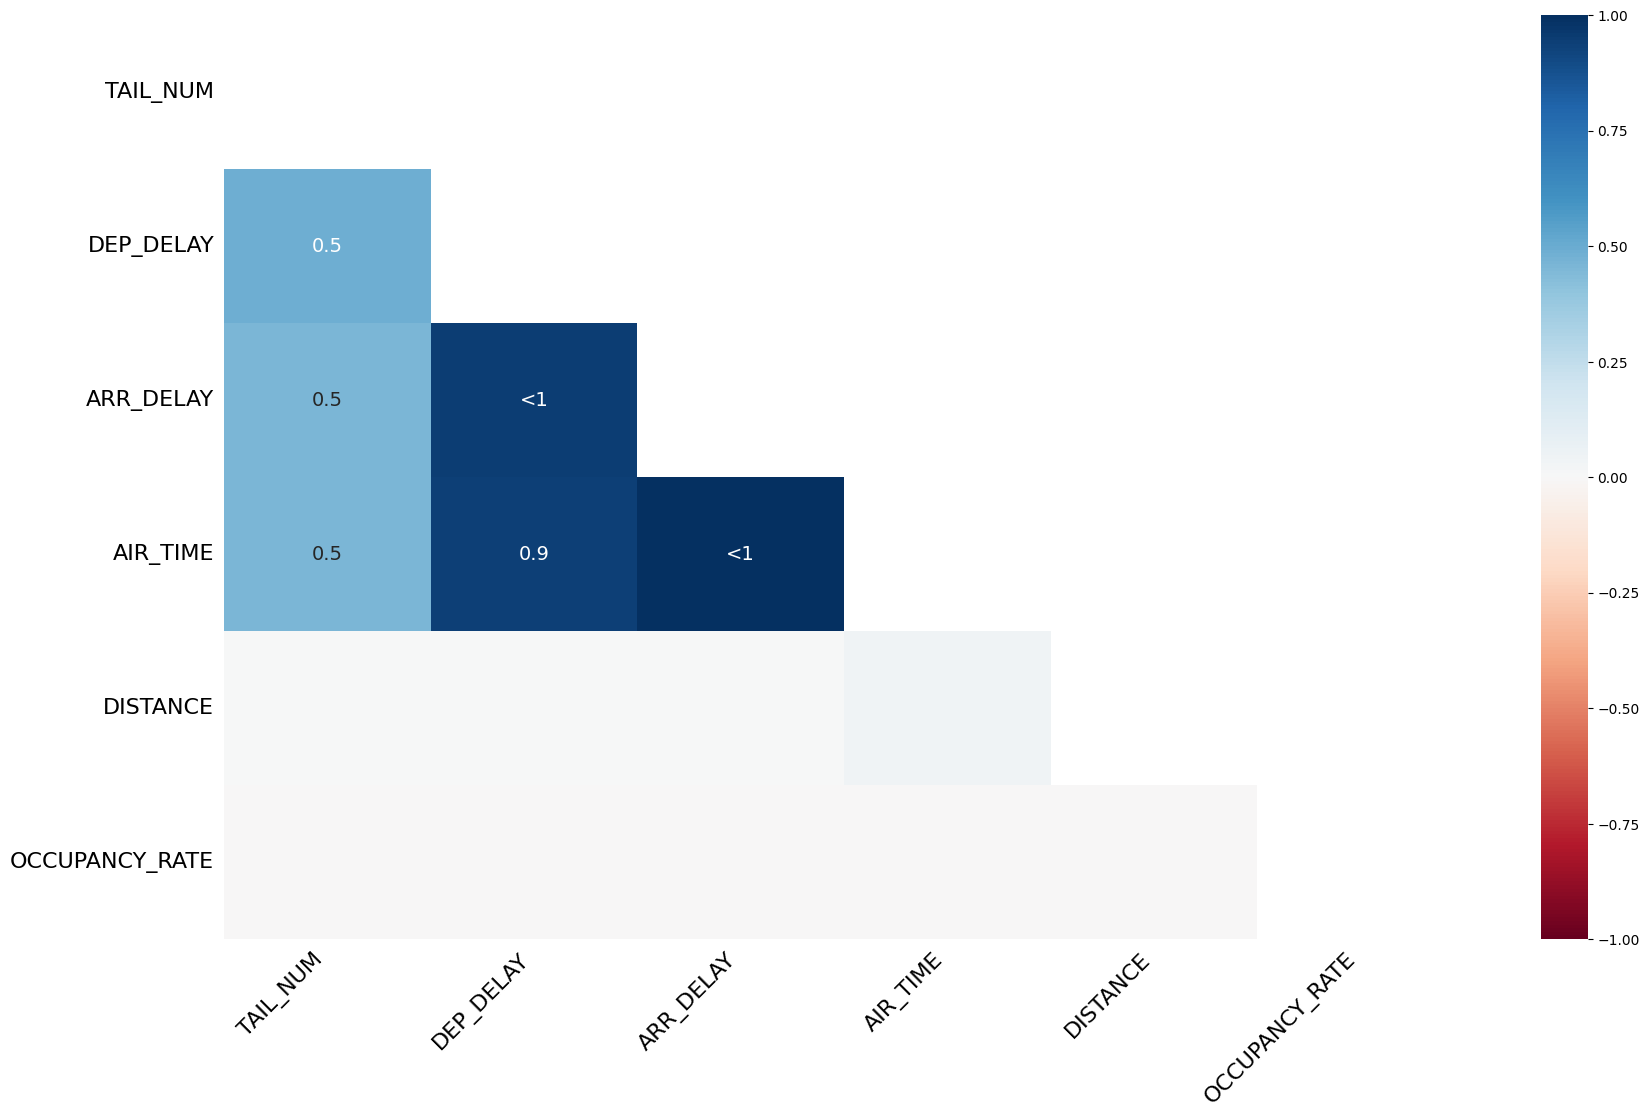

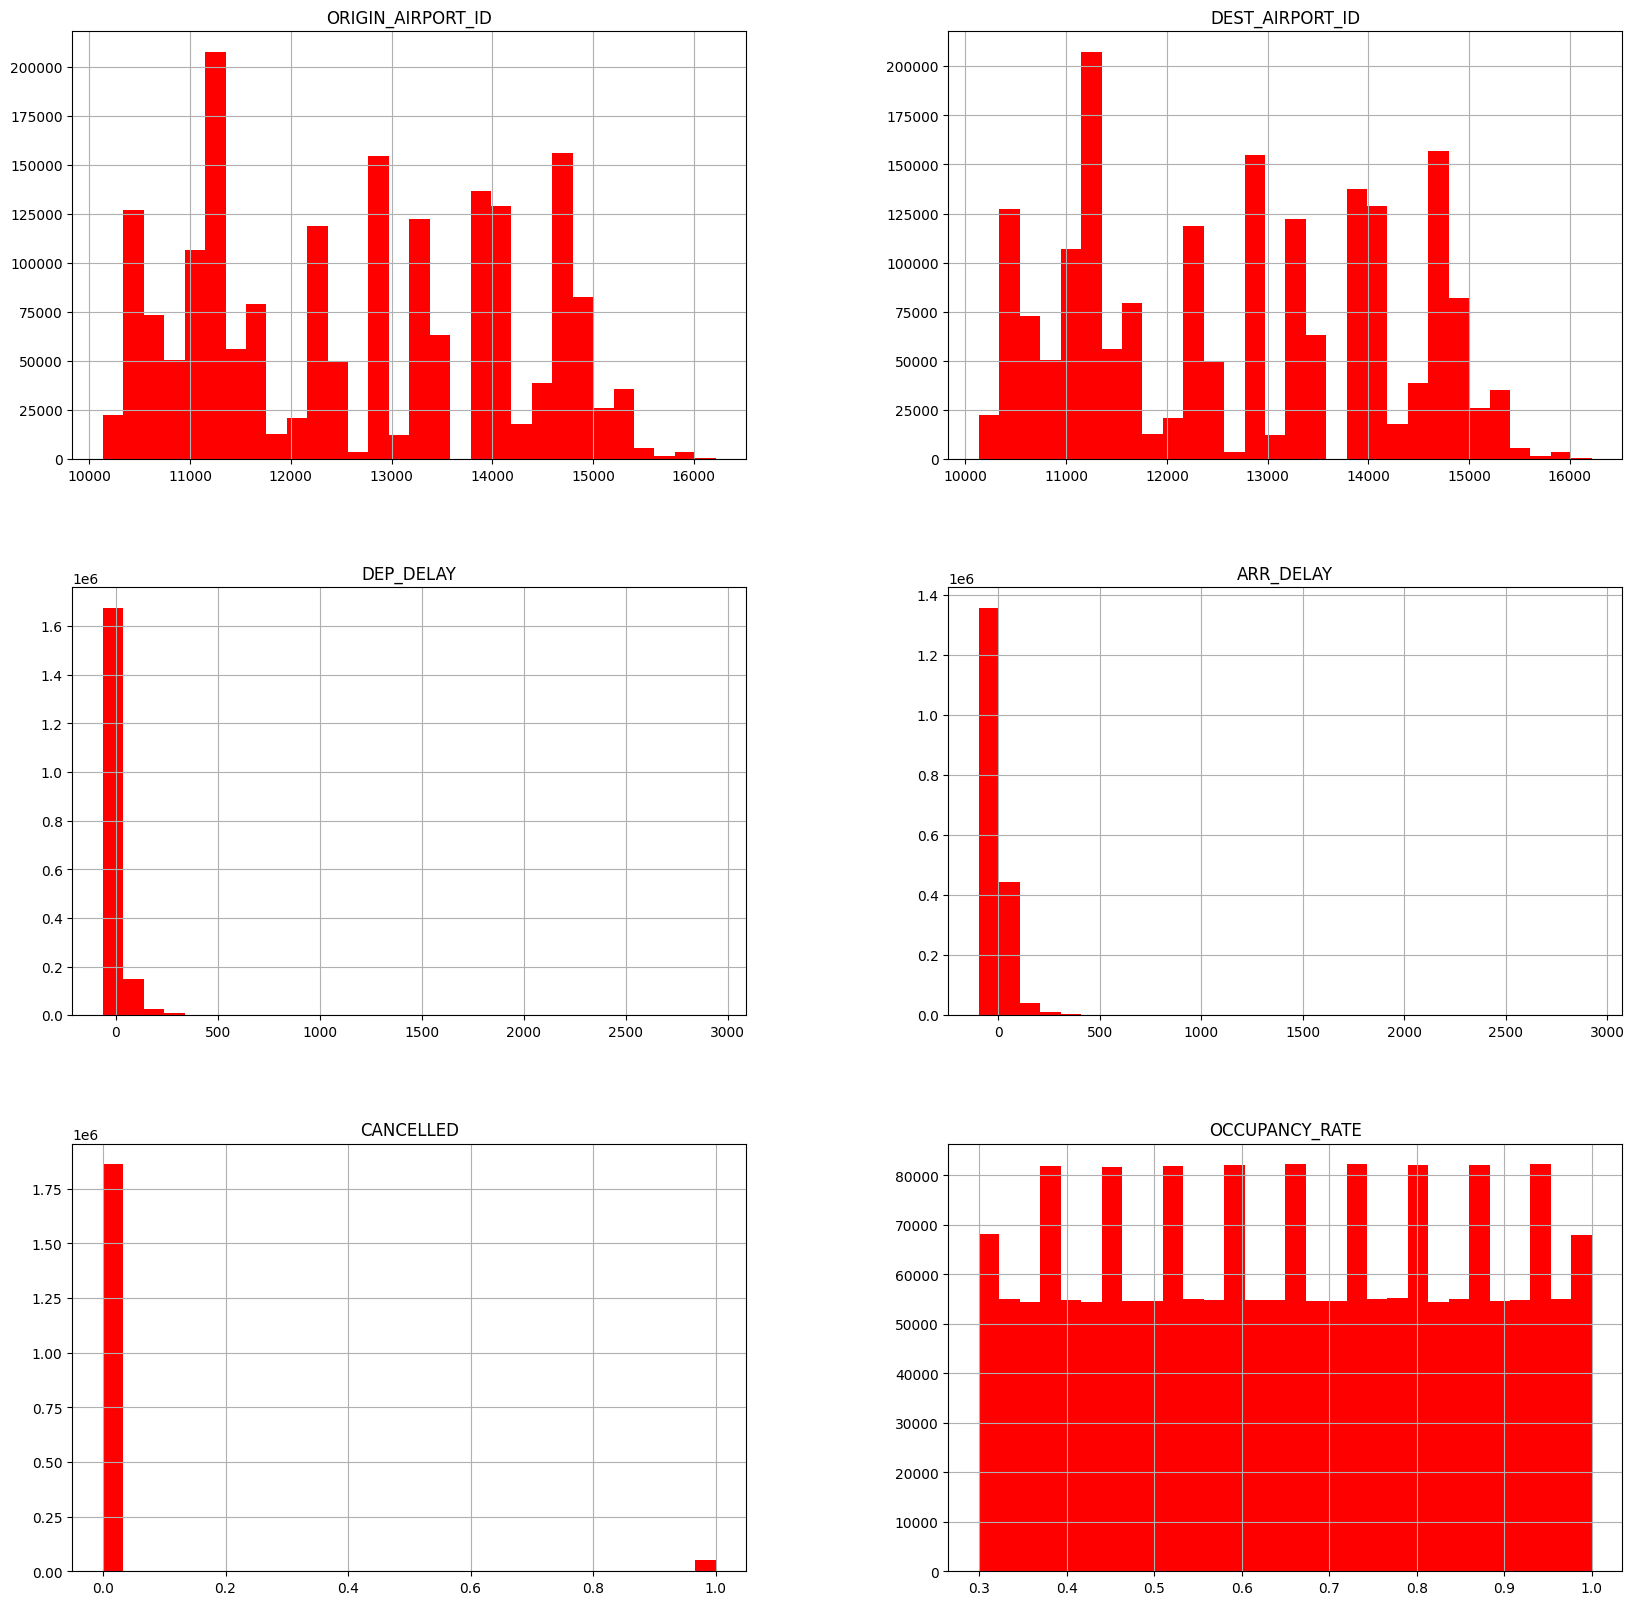


DataFrame Data Sample:
      FL_DATE OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID ORIGIN  \
0  2019-03-02         WN   N955WN              4591              14635    RSW   
1  2019-03-02         WN   N8686A              3231              14635    RSW   
2  2019-03-02         WN   N201LV              3383              14635    RSW   
3  2019-03-02         WN   N413WN              5498              14635    RSW   
4  2019-03-02         WN   N7832A              6933              14635    RSW   
5  2019-03-02         WN   N492WN              3960              14635    RSW   

  ORIGIN_CITY_NAME  DEST_AIRPORT_ID DESTINATION    DEST_CITY_NAME  DEP_DELAY  \
0   Fort Myers, FL            11042         CLE     Cleveland, OH       -8.0   
1   Fort Myers, FL            11066         CMH      Columbus, OH        1.0   
2   Fort Myers, FL            11066         CMH      Columbus, OH        0.0   
3   Fort Myers, FL            11066         CMH      Columbus, OH       11.0   
4   Fort

In [ ]:
#Create function to perform quick EDA and run it.
def quick_eda(df):
    """
    Perform a quick exploratory data analysis on a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """

    print("DataFrame Shape:")
    print(df.shape)

    print("\nDataFrame Info:")
    print(df.info())

    print("\nDataFrame Description:")
    print(df.describe(include='all'))

    print("\nMissing Values:")
    print(df.isnull().sum())
    msno.heatmap(df) #The bar plot below shows columns with missing values graphically.
    df.hist(bins =30, figsize=(20,20), color = 'r')
    plt.show()

    print("\nDataFrame Data Sample:")
    print(df.head(6))






#Run Quick EDA
quick_eda(hr_df)

In [ ]:
#Perform Data Cleaning Operations
def clean_numeric_columns(df, numeric_columns):
    """
    Clean specified numeric columns in a DataFrame and remove duplicates.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        numeric_columns (list): List of column names to check for numeric values.

    Returns:
        dict: A dictionary with counts of cleaned rows for each numeric column, along with cleaning operations performed.
    """

    # Step 1: Initialize cleaning information
    cleaning_info = {col: {'total_cleaned': 0, 'operations': []} for col in numeric_columns}

    # Step 2: Remove duplicate rows
    initial_row_count = df.shape[0]
    df.drop_duplicates(inplace=True)
    duplicate_count = initial_row_count - df.shape[0]
    if duplicate_count > 0:
        cleaning_info['duplicates'] = {'total_cleaned': duplicate_count, 'operations': [f'Removed {duplicate_count} duplicate rows.']}

    # Step 3: Iterate over each specified numeric column
    for col in numeric_columns:
        # Step 4: Store original values to track changes
        before_cleaning = df[col].copy()

        # Step 5: Convert to numeric, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Step 6: Count invalid conversions (NaN values)
        invalid_conversion_count = before_cleaning.isna().sum() - df[col].isna().sum()
        if invalid_conversion_count > 0:
            cleaning_info[col]['total_cleaned'] += invalid_conversion_count
            cleaning_info[col]['operations'].append(f'Replaced {invalid_conversion_count} invalid string values with NaN.')

        # Step 7: Count negative values
        negative_count = (df[col] < 0).sum()

        # Step 8: Replace negative values with 0 (or absolute values)
        if negative_count > 0:
            df[col] = df[col].clip(lower=0)  # This replaces negative values with 0
            cleaning_info[col]['total_cleaned'] += negative_count
            cleaning_info[col]['operations'].append(f'Replaced {negative_count} negative values with positive.')

        # Step 19: Check for NaN values and replace with median
        if df[col].isna().any():
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)  # Replace NaN with median value
            cleaning_info[col]['operations'].append(f'Replaced NaN values with median: {median_value}.')

    # Step 10: Return the cleaning information
    return cleaning_info  # Return cleaning info only


# Step 1: Convert column names to lowercase
hr_df.columns = hr_df.columns.str.lower()

# Step 2: Specify columns to clean
numeric_columns = ['distance', 'air_time']

# Step 3: Clean the DataFrame and update hr_df directly
cleaning_info = clean_numeric_columns(hr_df, numeric_columns)


# Step 4: Display cleaning operations performed
print("\nCleaning Operations Performed:")
for column, info in cleaning_info.items():
    if column == 'duplicates':
        print(f"\n{info['operations'][0]}")
    else:
        print(f"\nColumn '{column}':")
        print(f"Total Rows Cleaned: {info['total_cleaned']}")
        for operation in info['operations']:
            print(f"- {operation}")


Cleaning Operations Performed:

Column 'distance':
Total Rows Cleaned: 23
- Replaced 23 negative values with positive.
- Replaced NaN values with median: 606.0.

Column 'air_time':
Total Rows Cleaned: 11
- Replaced 11 negative values with positive.
- Replaced NaN values with median: 91.0.

Removed 4545 duplicate rows.


In [ ]:
# 5. Check for route with multiple distance
multiple_distances = hr_df.groupby(['origin', 'destination'])['distance'].nunique().reset_index() # Group by 'origin' and 'destination', and count unique distances
multiple_values = multiple_distances[multiple_distances['distance'] > 1] # Filter for groups with more than one unique distance
total_routes = multiple_values.count() # Count the total number of such routes

print(f"Total number of routes with multiple distances: {total_routes}")

Total number of routes with multiple distances: origin         67
destination    67
distance       67
dtype: int64


DataFrame Shape:
(1911341, 16)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1911341 entries, 0 to 1911340
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fl_date            object 
 1   op_carrier         object 
 2   tail_num           object 
 3   op_carrier_fl_num  object 
 4   origin_airport_id  int64  
 5   origin             object 
 6   origin_city_name   object 
 7   dest_airport_id    int64  
 8   destination        object 
 9   dest_city_name     object 
 10  dep_delay          float64
 11  arr_delay          float64
 12  cancelled          float64
 13  air_time           float64
 14  distance           float64
 15  occupancy_rate     float64
dtypes: float64(6), int64(2), object(8)
memory usage: 247.9+ MB
None

DataFrame Description:
           fl_date op_carrier tail_num  op_carrier_fl_num  origin_airport_id  \
count      1911341    1911341  1899230          1911341.0       1.911341e+06   
unique         

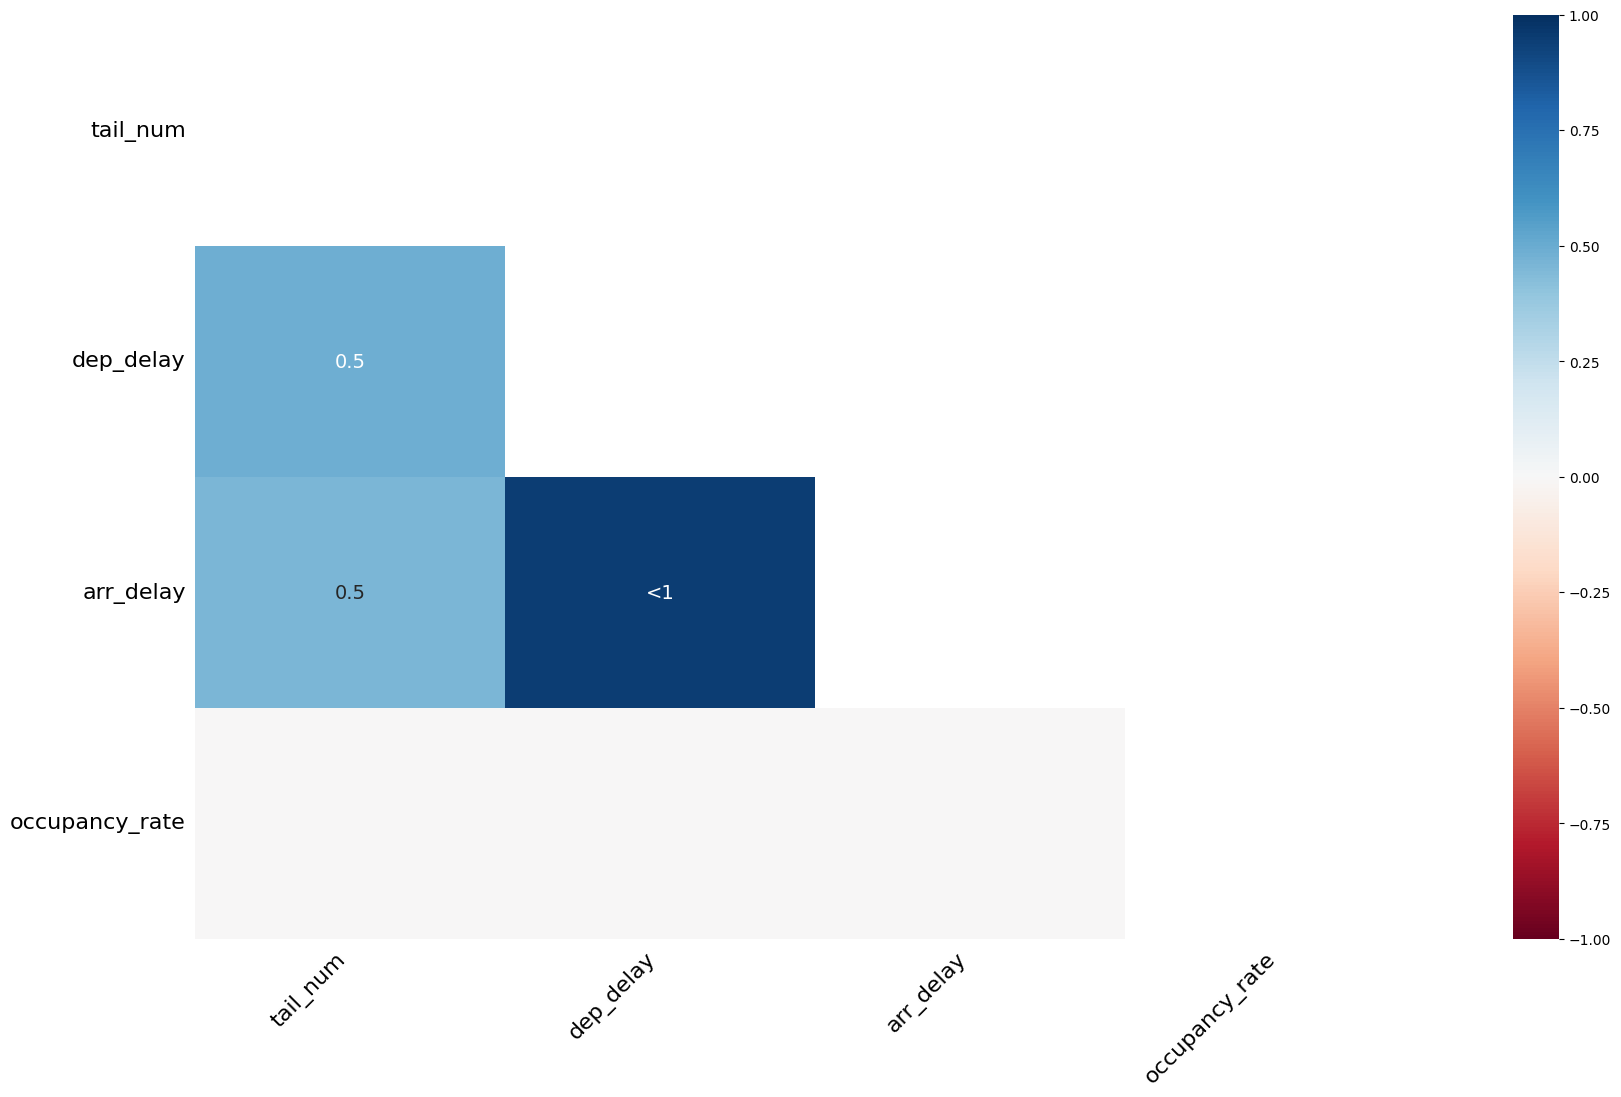

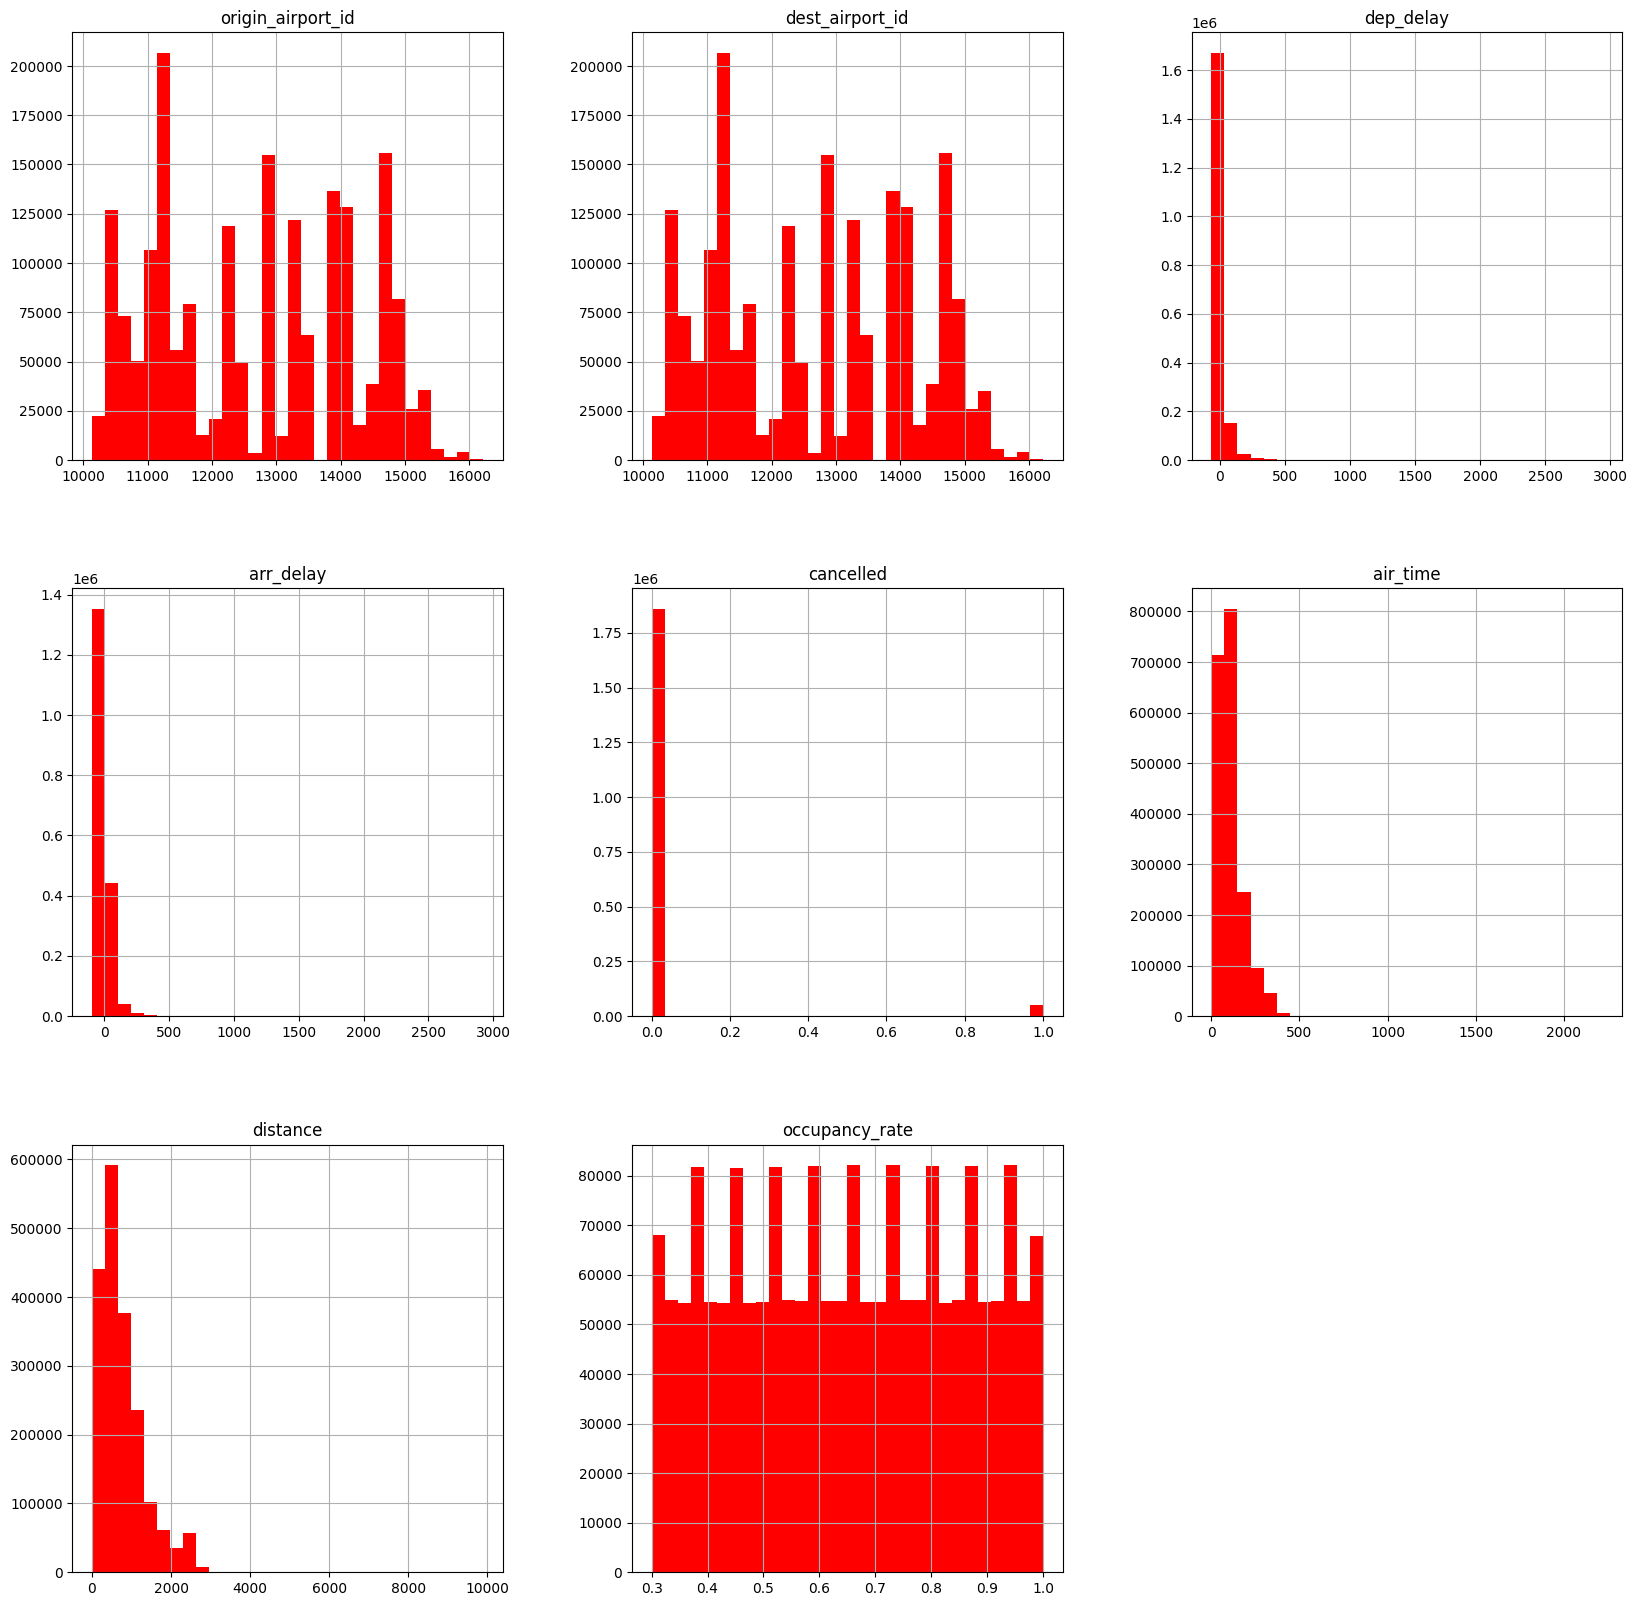


DataFrame Data Sample:
      fl_date op_carrier tail_num op_carrier_fl_num  origin_airport_id origin  \
0  2019-03-02         WN   N955WN              4591              14635    RSW   
1  2019-03-02         WN   N8686A              3231              14635    RSW   
2  2019-03-02         WN   N201LV              3383              14635    RSW   
3  2019-03-02         WN   N413WN              5498              14635    RSW   
4  2019-03-02         WN   N7832A              6933              14635    RSW   
5  2019-03-02         WN   N492WN              3960              14635    RSW   

  origin_city_name  dest_airport_id destination    dest_city_name  dep_delay  \
0   Fort Myers, FL            11042         CLE     Cleveland, OH       -8.0   
1   Fort Myers, FL            11066         CMH      Columbus, OH        1.0   
2   Fort Myers, FL            11066         CMH      Columbus, OH        0.0   
3   Fort Myers, FL            11066         CMH      Columbus, OH       11.0   
4   Fort

In [ ]:
#Perform Quick EDA again
quick_eda(hr_df)

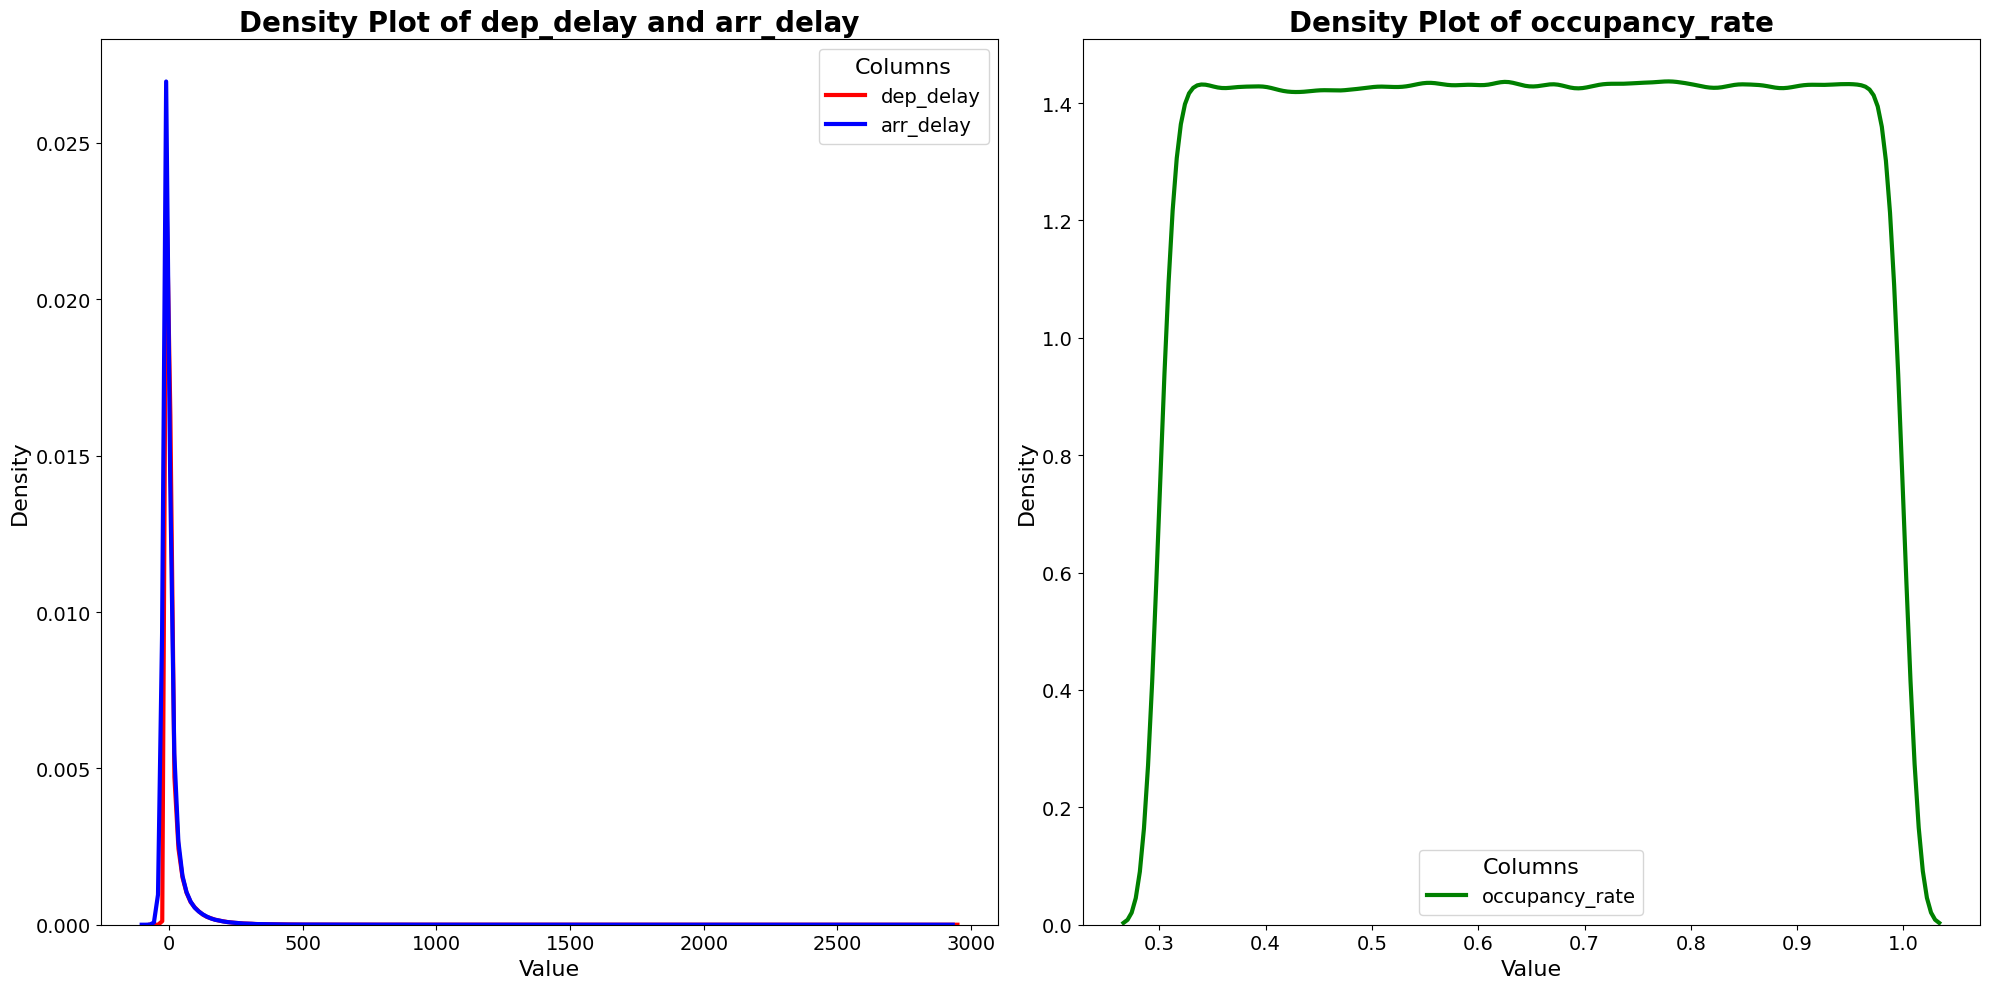

In [ ]:
#7. Use Density plots to identify skewness of dataset.

# Create a figure with 1 row and 2 columns for the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figure size for better visualization

# First plot: dep_delay and arr_delay
sns.kdeplot(hr_df['dep_delay'], label='dep_delay', linewidth=3, color='red', ax=axes[0])
sns.kdeplot(hr_df['arr_delay'], label='arr_delay', linewidth=3, color='blue', ax=axes[0])

# Customize legend, labels, and title for the first plot
axes[0].legend(title='Columns', fontsize=14, title_fontsize='16')  # Bigger legend and title font
axes[0].set_xlabel('Value', fontsize=16)  # Larger x-axis label font size
axes[0].set_ylabel('Density', fontsize=16)  # Larger y-axis label font size
axes[0].set_title('Density Plot of dep_delay and arr_delay', fontsize=20, weight='bold')  # Title with bold font
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Bigger tick labels

# Second plot: occupancy_rate
sns.kdeplot(hr_df['occupancy_rate'], label='occupancy_rate', linewidth=3, color='green', ax=axes[1])

# Customize legend, labels, and title for the second plot
axes[1].legend(title='Columns', fontsize=14, title_fontsize='16')  # Bigger legend and title font
axes[1].set_xlabel('Value', fontsize=16)  # Larger x-axis label font size
axes[1].set_ylabel('Density', fontsize=16)  # Larger y-axis label font size
axes[1].set_title('Density Plot of occupancy_rate', fontsize=20, weight='bold')  # Title with bold font
axes[1].tick_params(axis='both', which='major', labelsize=14)  # Bigger tick labels

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

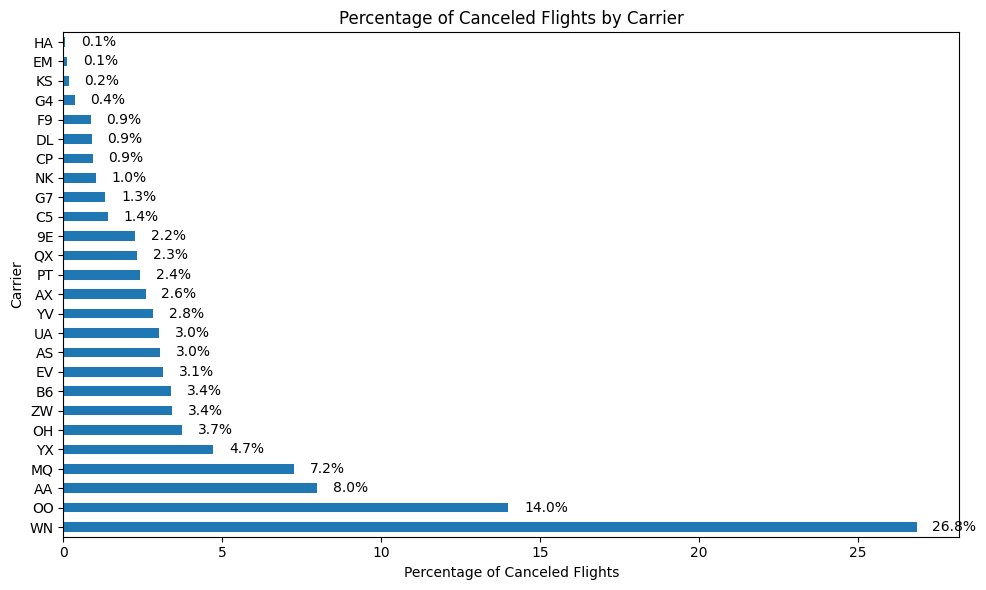

In [ ]:
#Visualize Cancelled Flights by Carrier


def visualize_canceled_flights_by_carrier(df):
    canceled_flights = df[df['cancelled'] == 1]
    carrier_cancel_percentage = (canceled_flights.groupby('op_carrier').size() / canceled_flights.shape[0]) * 100
    carrier_cancel_percentage = carrier_cancel_percentage.fillna(0).sort_values(ascending=False)

    ax = carrier_cancel_percentage.plot(kind='barh', figsize=(10, 6))
    for i, percentage in enumerate(carrier_cancel_percentage):
        ax.text(percentage + 0.5, i, f'{percentage:.1f}%', va='center')

    plt.xlabel('Percentage of Canceled Flights')
    plt.ylabel('Carrier')
    plt.title('Percentage of Canceled Flights by Carrier')
    plt.tight_layout()
    plt.show()

#Run function
visualize_canceled_flights_by_carrier(hr_df)

In [ ]:
#Percentage and Count of Non-Cancelled Flights by Status
# Function to create flight status column
def determine_flight_status(row):
    dep_delay = row['dep_delay']
    arr_delay = row['arr_delay']
    # Status based on delays: 'On Time' if both are 0, 'Early' if both are negative,
    # 'Late' if both are positive, and 'Mixed' if one is negative and the other is positive.
    if dep_delay == 0 and arr_delay == 0:
        return 'On Time'
    elif dep_delay < 0 and arr_delay < 0:
        return 'Early'
    elif dep_delay > 0 and arr_delay > 0:
        return 'Late'
    else:
        return 'Mixed'

# Apply the function to each row to create a new 'status' column
hr_df['status'] = hr_df.apply(determine_flight_status, axis=1)

# Display the updated DataFrame with the new 'status' column
print(hr_df['status'].unique())


['Early' 'Late' 'Mixed' 'On Time']


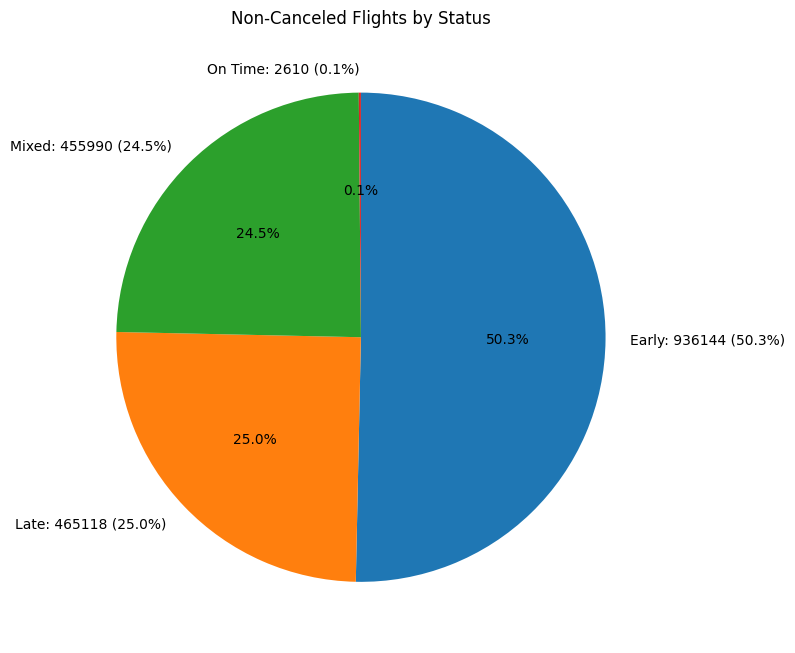

In [ ]:
#Visualize Non_Cancelled Flights by Status


def visualize_non_canceled_flights_by_status(df):
    non_canceled_flights = df[df['cancelled'] == 0]
    status_percentage = (non_canceled_flights.groupby('status').size() / non_canceled_flights.shape[0]) * 100
    status_percentage = status_percentage.fillna(0).sort_values(ascending=False)

    plt.figure(figsize=(8, 8))
    plt.pie(non_canceled_flights.groupby('status').size(),
            labels=[f'{s}: {c} ({p:.1f}%)' for s, c, p in zip(status_percentage.index, non_canceled_flights.groupby('status').size(), status_percentage)],
            autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title('Non-Canceled Flights by Status')
    plt.tight_layout()
    plt.show()

# Run code
visualize_non_canceled_flights_by_status(hr_df)

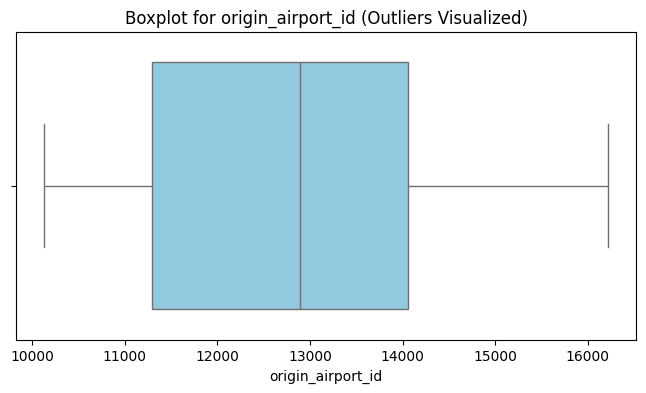

There are no outliers in column 'origin_airport_id'.


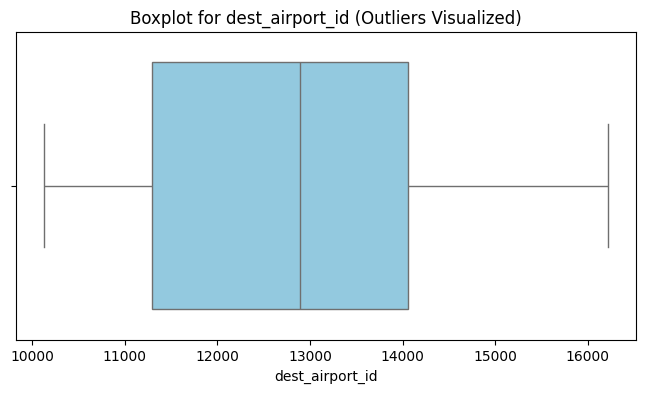

There are no outliers in column 'dest_airport_id'.


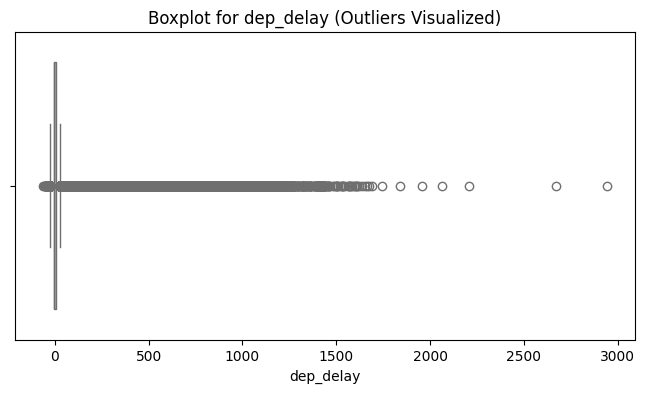

Outliers are present in column 'dep_delay'


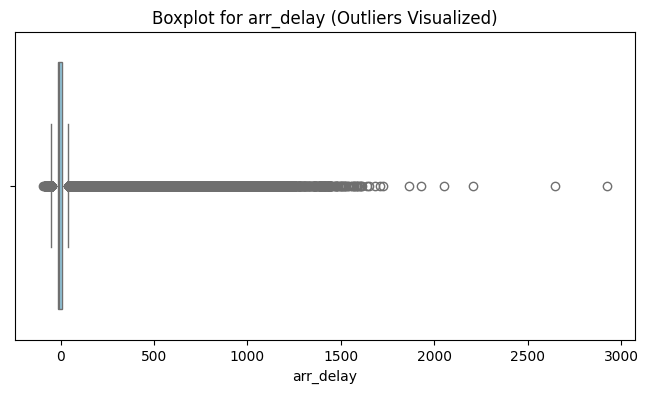

Outliers are present in column 'arr_delay'


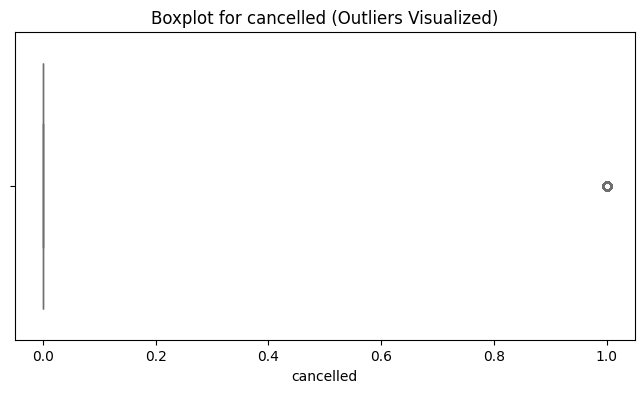

Outliers are present in column 'cancelled'


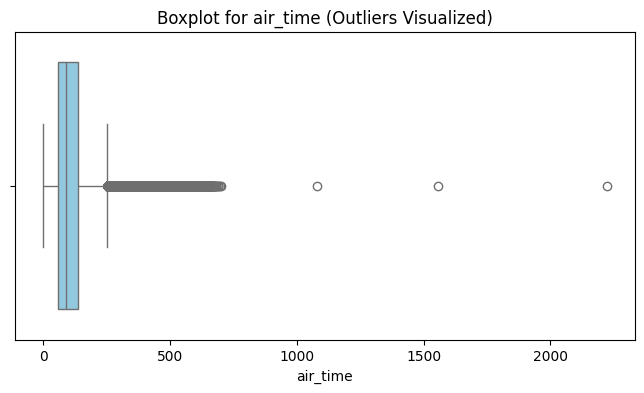

Outliers are present in column 'air_time'


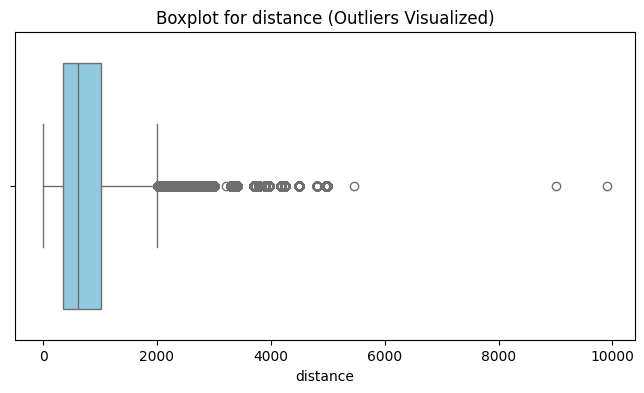

Outliers are present in column 'distance'


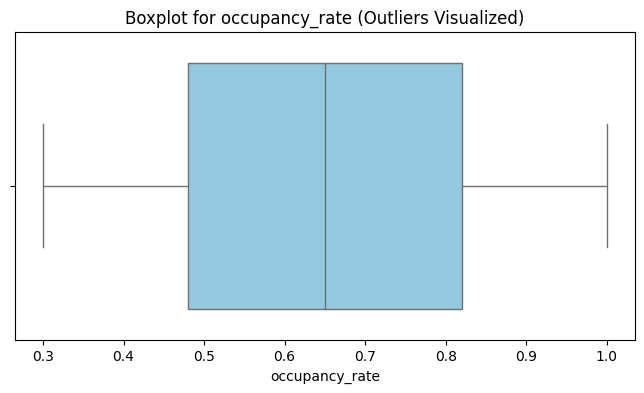

There are no outliers in column 'occupancy_rate'.


In [ ]:
# Find and Visualize Outliers Using Boxplot

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def find_outliers_boxplot(df):
    """
    Finds outliers in numerical columns of a DataFrame using the boxplot method and visualizes the boxplot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        None: Displays boxplots and prints outlier values for each numerical column.
    """

    # Filter numerical columns in the DataFrame
    numerical_columns = df.select_dtypes(include=['number']).columns

    for column in numerical_columns:
        # Calculate Q1, Q3, and IQR for the column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Determine the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers outside the lower and upper bounds
        outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Plot the boxplot to visualize the outliers
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column], color="skyblue")
        plt.title(f'Boxplot for {column} (Outliers Visualized)')
        plt.xlabel(column)
        plt.show()

        # Print outliers if present
        if not outliers.empty:
            print(f"Outliers are present in column '{column}'")
        else:
            print(f"There are no outliers in column '{column}'.")

#Run function to check for outliers
find_outliers_boxplot(hr_df)

Dataframe shape: (1911341, 17)
Data types:
 fl_date               object
op_carrier            object
tail_num              object
op_carrier_fl_num     object
origin_airport_id      int64
origin                object
origin_city_name      object
dest_airport_id        int64
destination           object
dest_city_name        object
dep_delay            float64
arr_delay            float64
cancelled            float64
air_time             float64
distance             float64
occupancy_rate       float64
status                object
dtype: object
Missing values:
 fl_date                  0
op_carrier               0
tail_num             12111
op_carrier_fl_num        0
origin_airport_id        0
origin                   0
origin_city_name         0
dest_airport_id          0
destination              0
dest_city_name           0
dep_delay            50216
arr_delay            55847
cancelled                0
air_time                 0
distance                 0
occupancy_rate          31


<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col

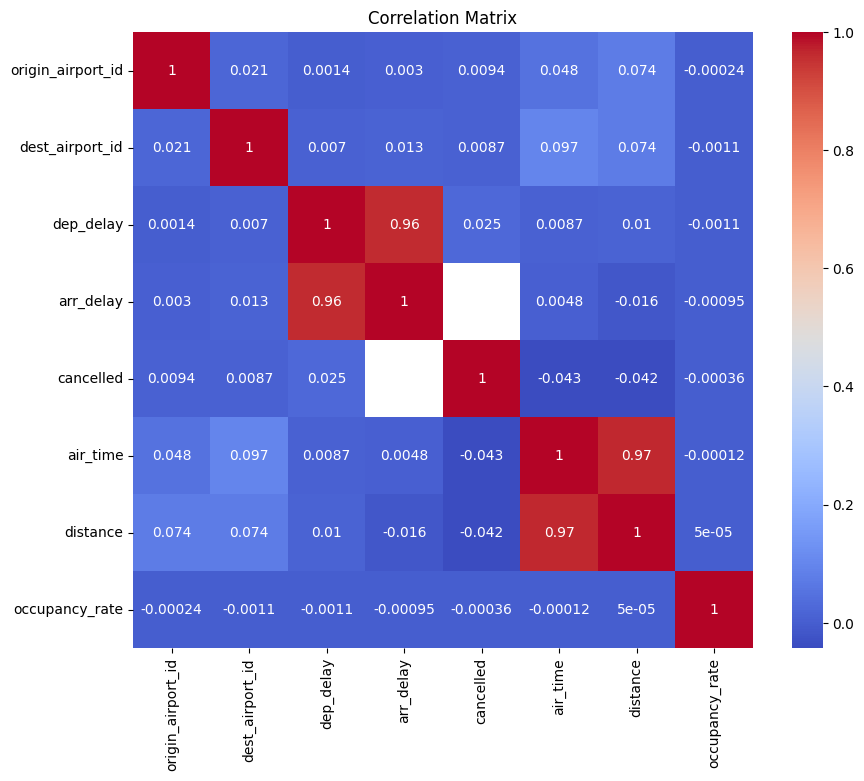

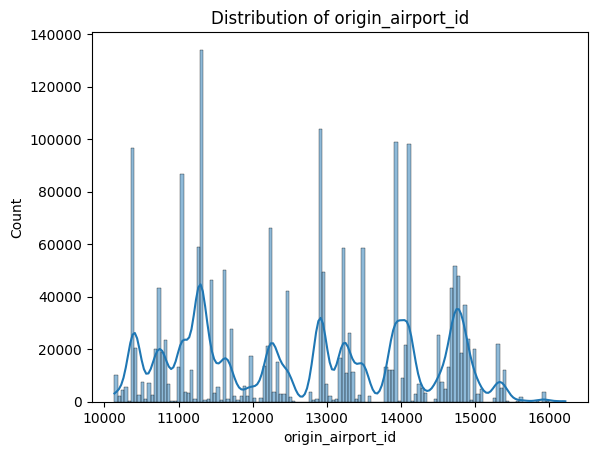

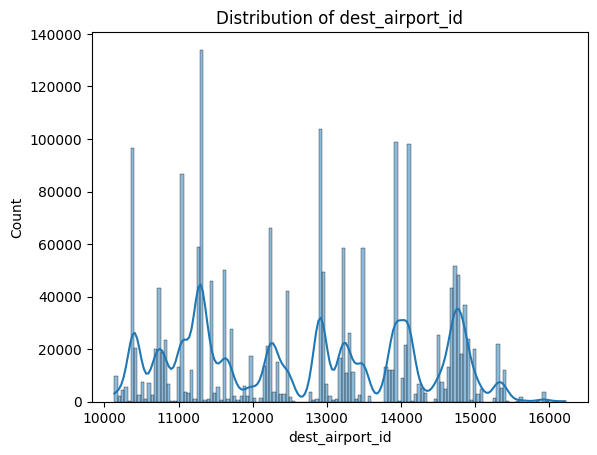

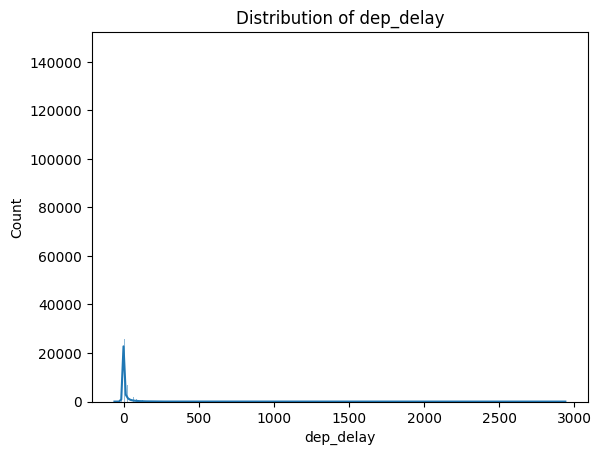

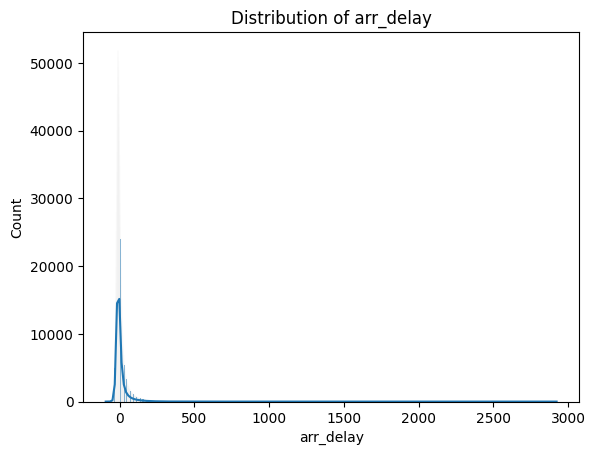

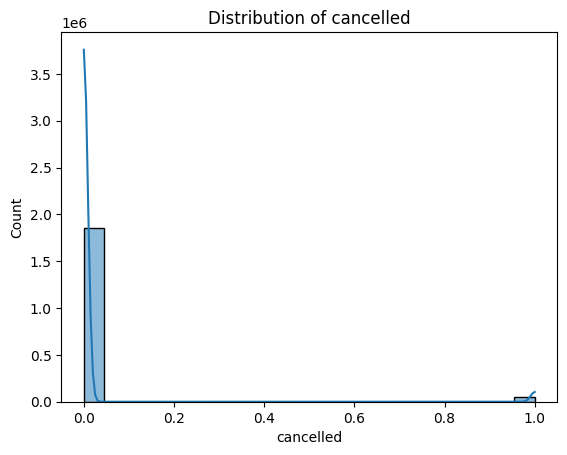

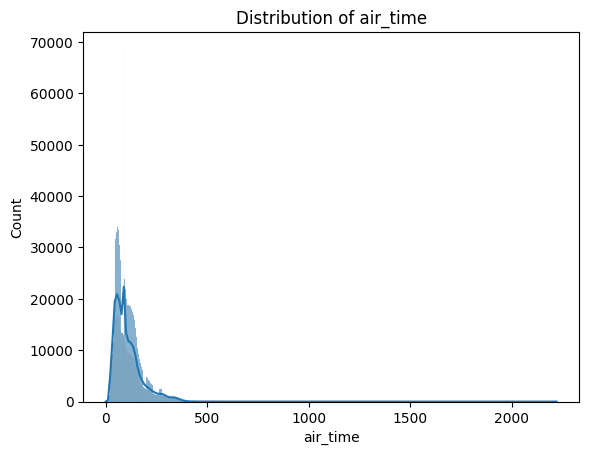

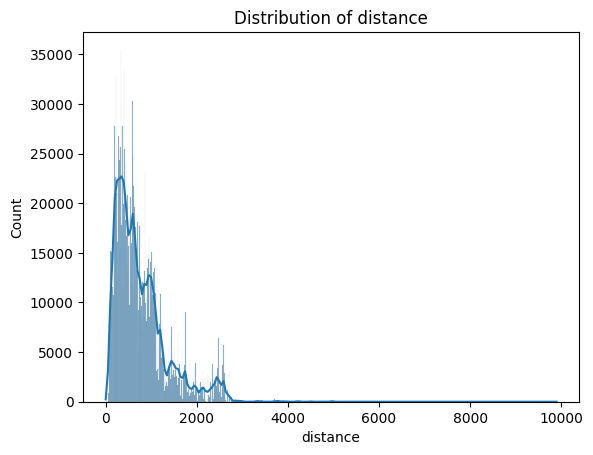

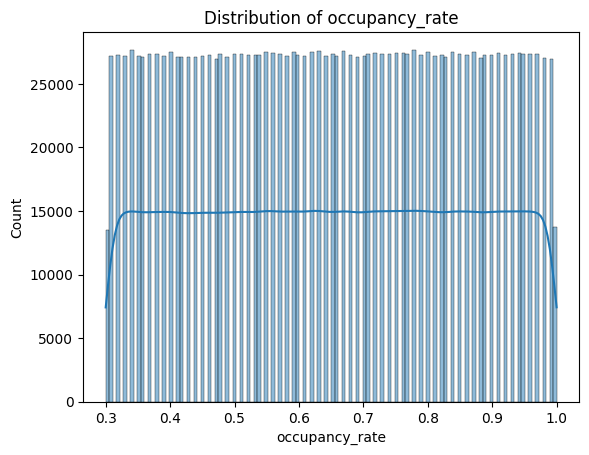

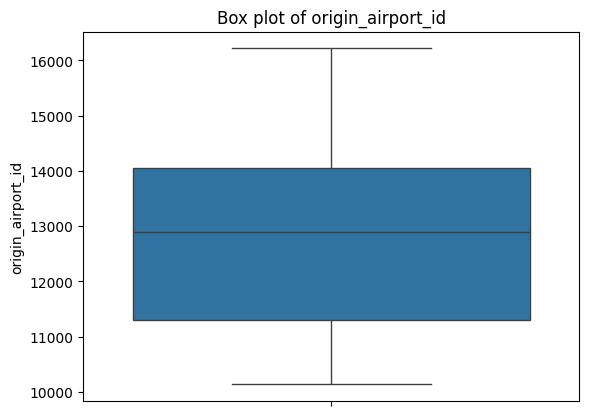

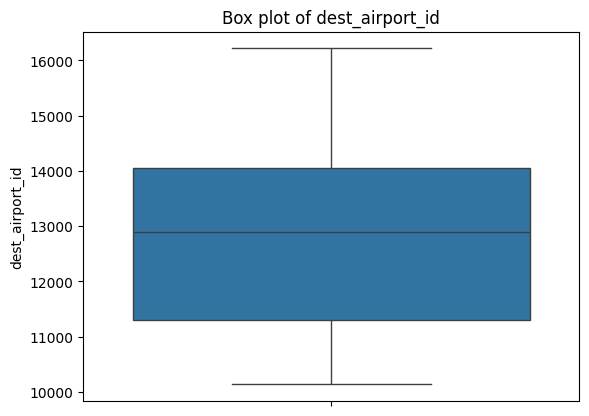

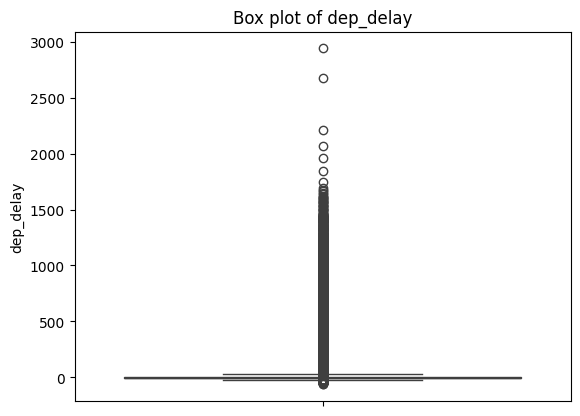

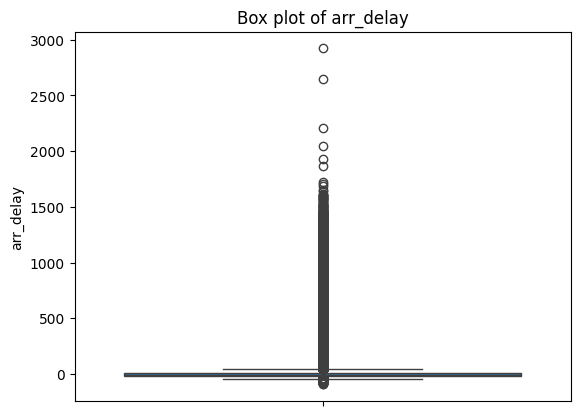

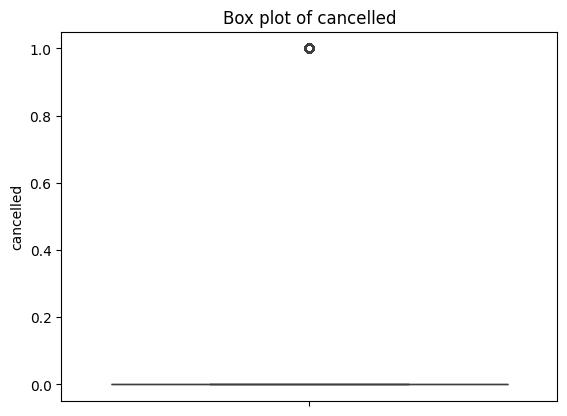

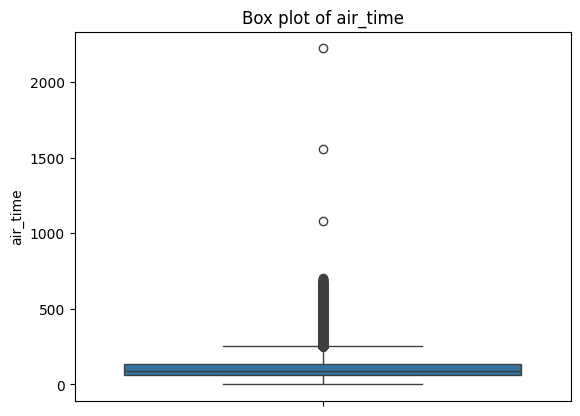

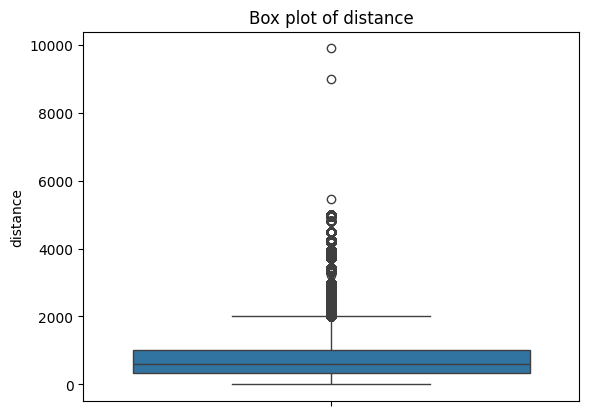

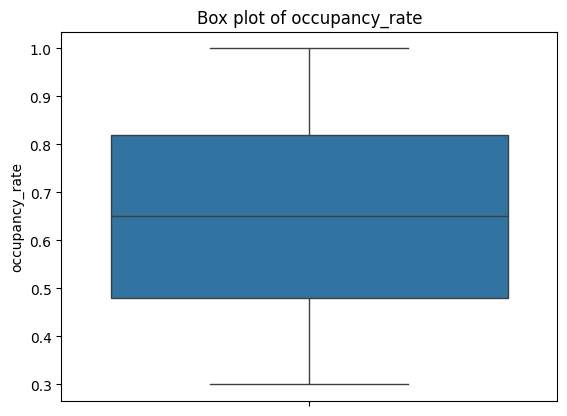

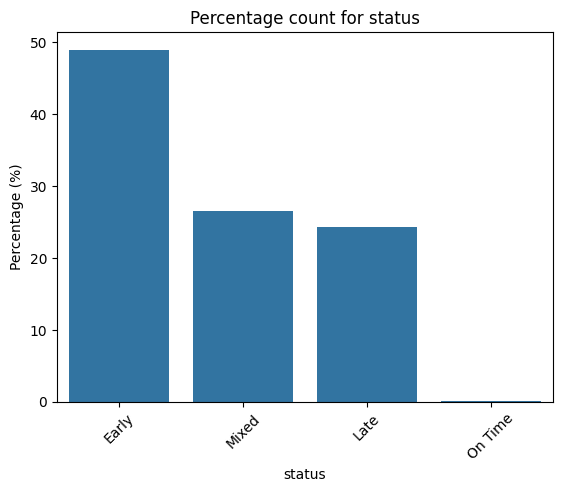

In [ ]:
#Create and run function to perform advanced EDA

def advanced_eda(df):
    """
    Performs advanced exploratory data analysis on a given dataframe.

    Args:
        df (pd.DataFrame): The dataframe to analyze.

    Returns:
        None
    """

    # Basic information
    print("Dataframe shape:", df.shape)
    print("Data types:\n", df.dtypes)
    print("Missing values:\n", df.isnull().sum())

    # Descriptive statistics
    print("Descriptive statistics:\n", df.describe(include='all'))  # Include both numeric and categorical data

    # Convert columns with dates to datetime if applicable
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col])
                print(f"Converted {col} to datetime format.")
            except ValueError:
                pass  # If conversion fails, leave it as is.

    # Correlation matrix for numerical columns
    num_cols = df.select_dtypes(include=np.number).columns
    if len(num_cols) > 1:
        corr_matrix = df[num_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
        plt.title("Correlation Matrix")
        plt.show()
    else:
        print("Not enough numerical columns for correlation matrix.")

    # Distribution plots for numerical features
    for col in num_cols:
        plt.figure()
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

    # Box plots for numerical features
    for col in num_cols:
        plt.figure()
        sns.boxplot(y=df[col])
        plt.title(f"Box plot of {col}")
        plt.show()

    # Count plots for categorical features with less than 25 unique values
    cat_cols = df.select_dtypes(exclude=np.number).columns
    for col in cat_cols:
        if df[col].nunique() < 25:  # Only consider categorical columns with less than 25 unique values
            count_pct = df[col].value_counts(normalize=True) * 100
            plt.figure()
            sns.barplot(x=count_pct.index, y=count_pct.values)
            plt.title(f"Percentage count for {col}")
            plt.ylabel("Percentage (%)")
            plt.xticks(rotation=45)
            plt.show()

# Run the function
advanced_eda(hr_df)

In [ ]:
#Flight Analysis

def flight_analysis(df):
    """
    Performs analysis on flight data to calculate key statistics for Q1 2019.

    Args:
        df (pd.DataFrame): The dataframe containing flight data.
                           Expected columns: 'cancelled', 'fl_date', 'dep_delay', 'arr_delay', 'occupancy_rate'.

    Returns:
        None
    """

    # Convert fl_date to datetime, infer format automatically, handle errors
    df['fl_date'] = pd.to_datetime(df['fl_date'], errors='coerce', dayfirst=False)

    # 1. Percentage of flights cancelled and un-cancelled
    total_flights = len(df)
    cancelled_pct = df['cancelled'].mean() * 100
    uncancelled_pct = 100 - cancelled_pct
    print(f"{cancelled_pct:.2f}% flights were cancelled and {uncancelled_pct:.2f}% flights were un-cancelled in Q1 2019.")

    # 2. Count of flights per month
    flights_per_month = df.groupby(df['fl_date'].dt.month)['fl_date'].count()
    for month, flights in flights_per_month.items():
            print(f"Month {month} had {flights} flights")


    # 3. Percentage of flights that departed early (dep_delay < 0)
    early_departure_pct = (df['dep_delay'] < 0).mean() * 100
    print(f"{early_departure_pct:.2f}% flights departed early in Q1 2019.")

    # 4. Percentage of flights that arrived early (arr_delay < 0)
    early_arrival_pct = (df['arr_delay'] < 0).mean() * 100
    print(f"{early_arrival_pct:.2f}% flights arrived early in Q1 2019.")

    # 5. Percentage of flights with occupancy rates greater than 50%
    flights_with_high_occupancy = df[df['occupancy_rate'] > 0.5].shape[0]
    high_occupancy_pct = (flights_with_high_occupancy / total_flights) * 100
    print(f"{high_occupancy_pct:.2f}% flights had greater than 50% occupancy rates in Q1 2019.")


flight_analysis(hr_df)

2.69% flights were cancelled and 97.31% flights were un-cancelled in Q1 2019.
Month 1.0 had 638649 flights
Month 2.0 had 582966 flights
Month 3.0 had 689221 flights
59.20% flights departed early in Q1 2019.
60.59% flights arrived early in Q1 2019.
70.80% flights had greater than 50% occupancy rates in Q1 2019.


In [ ]:
"""
Key Findings from Flights Dataset Analysis

1. Dataset Overview
   - Shape of the dataset: (1915886, 16)
   - All column names were converted to lowercase from uppercase.
   - Top origin and destination for flights: Atlanta (ATL).

2. Data Cleaning
   - 4545 duplicate records were removed. Final shape: (1911341, 16).
   - Rows cleaned: 23 in distance, 11 in air_time.

3. Missing Values
   - Columns with missing values: tail_num, dep_delay, arr_delay, airtime, distance, occupancy_rate.

4. Distribution Analysis
   - For dep_delay and arr_delay, the mean is greater than the median, indicating a right-skewed distribution.

5. Data Type Conversion
   - Data types were converted to their appropriate types after inspecting each column.

6. Outliers
   - Outliers exist in key columns: arr_delay, dep_delay, occupancy_rate.
   - These outliers are retained, as removing them may under-report operational expenses.

7. Distance Data Issues
   - 67 routes had multiple distance values (more than one distance value for a route).
   - Distance between origin and destination must be unique.
   - Negative values were replaced with positive values, special characters with NaN,
     and string values were converted to their respective data types.

8. Flight Cancellation Statistics
   - Cancellation rate: 2.69% flights were cancelled, 97.31% were un-cancelled in Q1 2019.

9. Monthly Flight Counts
   - Month 1.0: 638649 flights (more than 550K).
   - Month 2.0: 582966 flights (more than 550K).
   - Month 3.0: 689221 flights (more than 550K).

10. Early Departure and Arrival Statistics
    - 59.20% of flights departed early in Q1 2019.
    - 60.59% of flights arrived early in Q1 2019.
    - 50.3% of flights both departed and arrived early in Q1 2019.
    - 70.80% of flights had greater than 50% occupancy rates in Q1 2019.
"""

'\nKey Findings from Flights Dataset Analysis\n\n1. Dataset Overview\n   - Shape of the dataset: (1915886, 16)\n   - All column names were converted to lowercase from uppercase.\n   - Top origin and destination for flights: Atlanta (ATL).\n\n2. Data Cleaning\n   - 4545 duplicate records were removed. Final shape: (1911341, 16).\n   - Rows cleaned: 23 in distance, 11 in air_time.\n\n3. Missing Values\n   - Columns with missing values: tail_num, dep_delay, arr_delay, airtime, distance, occupancy_rate.\n\n4. Distribution Analysis\n   - For dep_delay and arr_delay, the mean is greater than the median, indicating a right-skewed distribution.\n\n5. Data Type Conversion\n   - Data types were converted to their appropriate types after inspecting each column.\n\n6. Outliers\n   - Outliers exist in key columns: arr_delay, dep_delay, occupancy_rate.\n   - These outliers are retained, as removing them may under-report operational expenses.\n\n7. Distance Data Issues\n   - 67 routes had multiple di

Airport Codes Analysis

In [ ]:
##Let's import the Flight.csv file into Python using Pandas as follows:
#Assuming ac_df is the DataFrame
ac_df = pd.read_csv(r'/content/drive/MyDrive/sample_data/Airport_Codes.csv')

DataFrame Shape:
(55369, 8)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55369 entries, 0 to 55368
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          55369 non-null  object 
 1   NAME          55369 non-null  object 
 2   ELEVATION_FT  48354 non-null  float64
 3   CONTINENT     27526 non-null  object 
 4   ISO_COUNTRY   55122 non-null  object 
 5   MUNICIPALITY  49663 non-null  object 
 6   IATA_CODE     9182 non-null   object 
 7   COORDINATES   55369 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.4+ MB
None

DataFrame Description:
                 TYPE                         NAME  ELEVATION_FT CONTINENT  \
count           55369                        55369  48354.000000     27526   
unique              7                        52426           NaN         6   
top     small_airport  Centre Hospitalier Heliport           NaN        EU   
freq            34120   

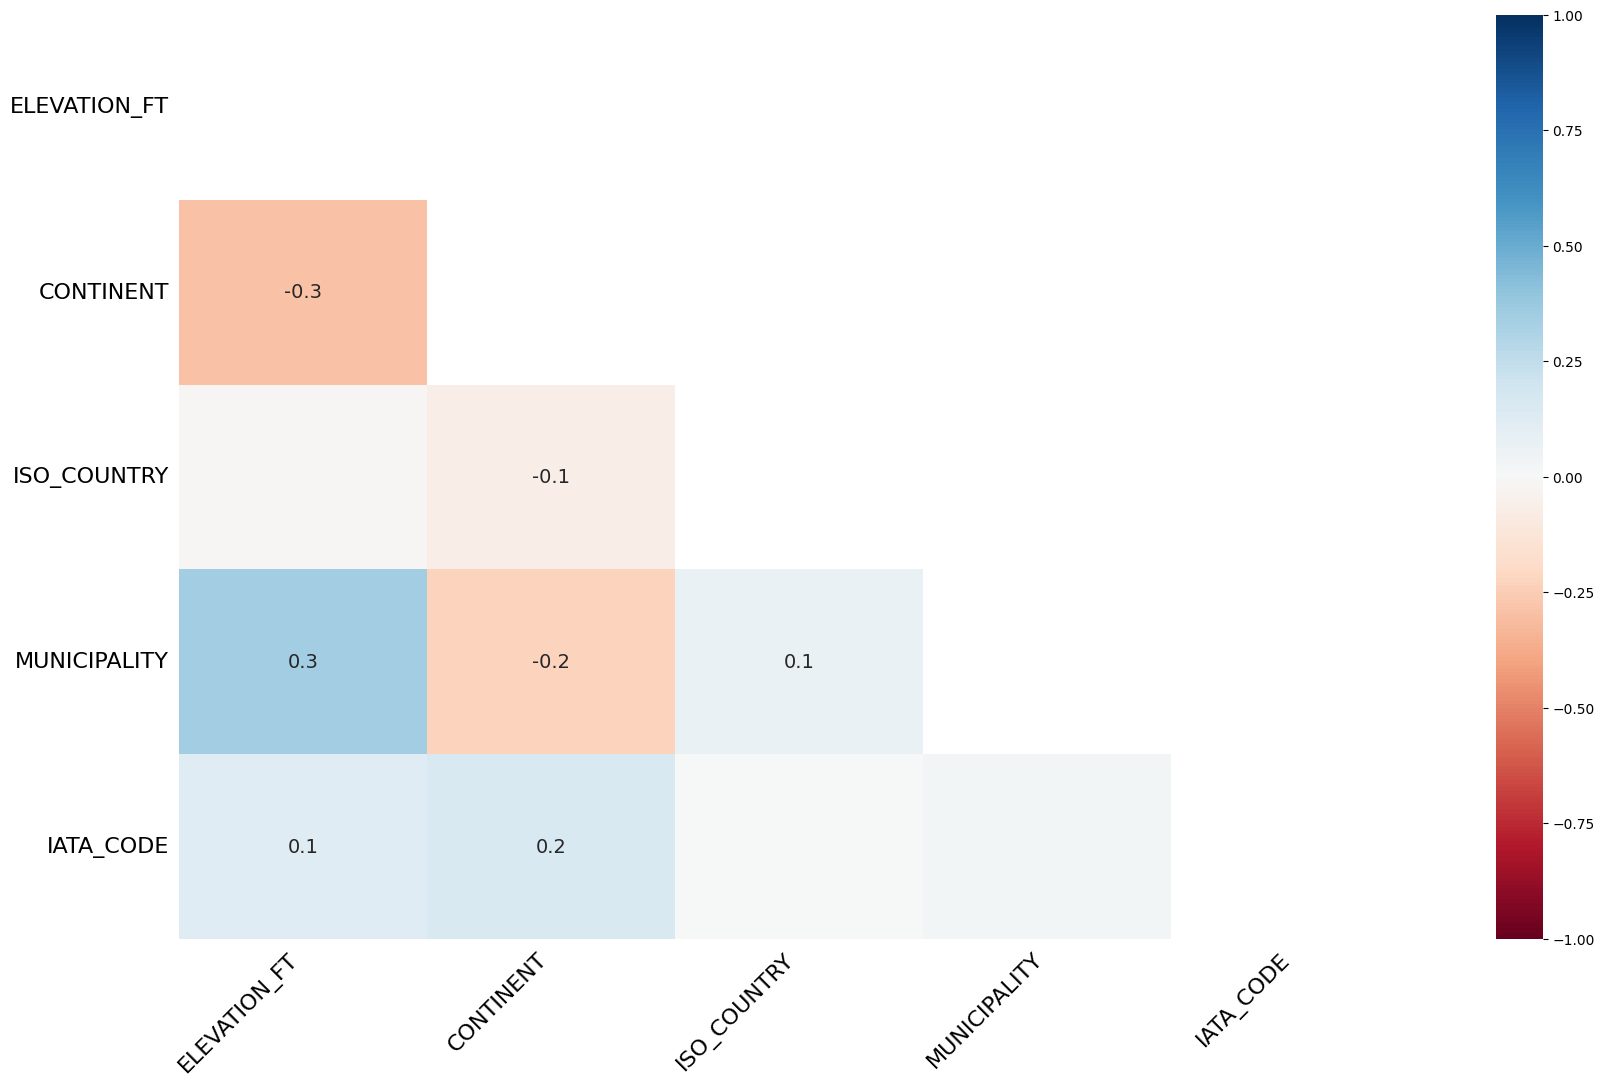

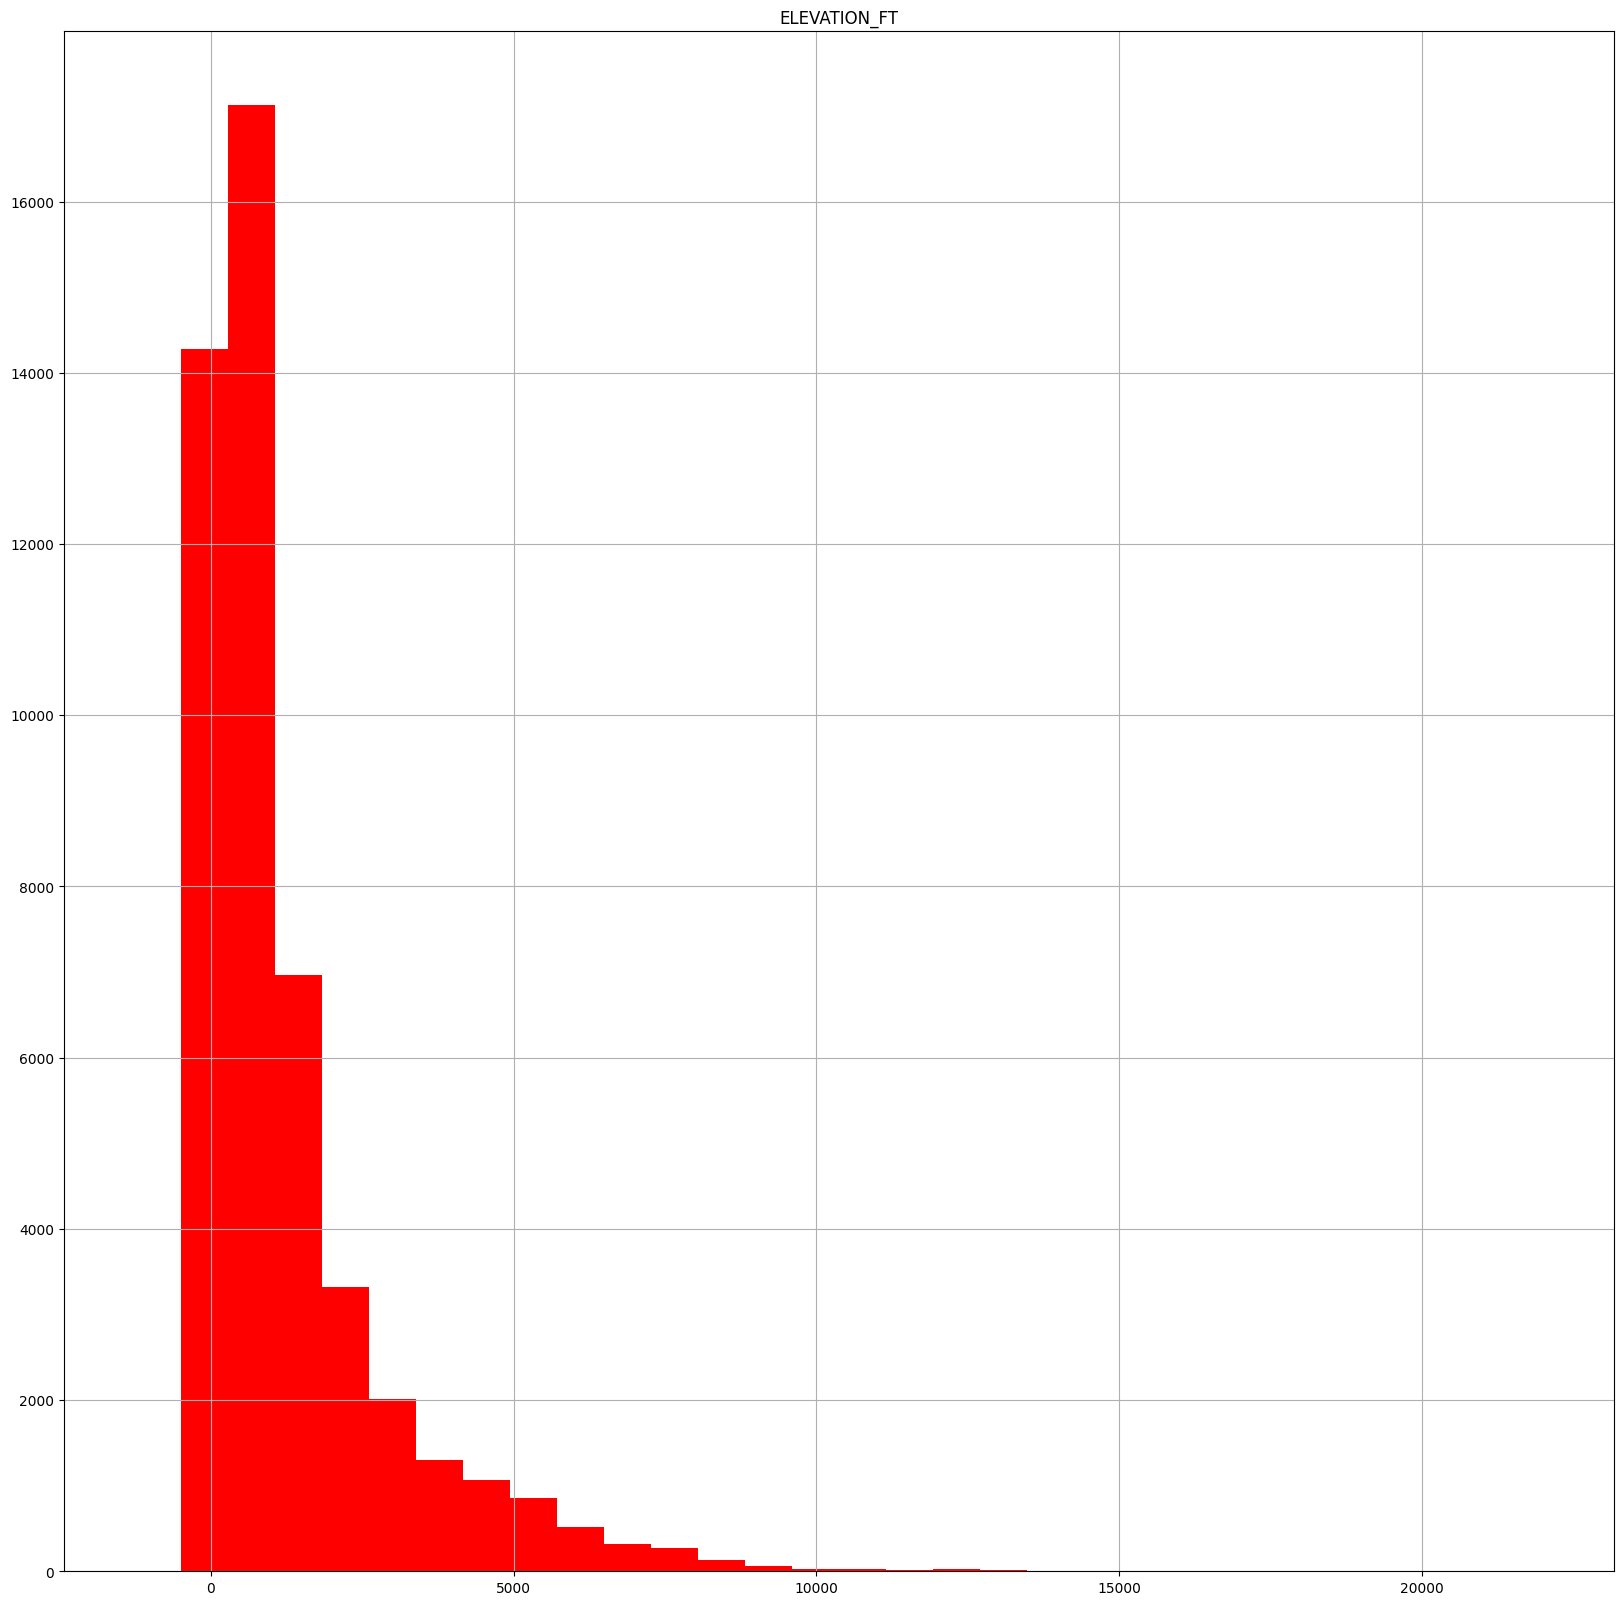


DataFrame Data Sample:
            TYPE                                NAME  ELEVATION_FT CONTINENT  \
0       heliport                   Total Rf Heliport          11.0       NaN   
1  small_airport                Aero B Ranch Airport        3435.0       NaN   
2  small_airport                        Lowell Field         450.0       NaN   
3  small_airport                        Epps Airpark         820.0       NaN   
4         closed  Newport Hospital & Clinic Heliport         237.0       NaN   
5  small_airport                      Fulton Airport        1100.0       NaN   

  ISO_COUNTRY  MUNICIPALITY IATA_CODE                            COORDINATES  
0          US      Bensalem       NaN     -74.93360137939453, 40.07080078125  
1          US         Leoti       NaN                 -101.473911, 38.704022  
2          US  Anchor Point       NaN            -151.695999146, 59.94919968  
3          US       Harvest       NaN  -86.77030181884766, 34.86479949951172  
4          US       

In [ ]:
#Run quick EDA
quick_eda(ac_df)

In [ ]:
#Perform Data Cleaning Operation

def clean_df(df):
    df.columns = df.columns.str.lower()  # Convert column names to lowercase
    initial_row_count = len(df)
    df.drop_duplicates(inplace=True)  # Remove duplicates
    duplicates_cleaned = initial_row_count - len(df)
    print(f"\nCleaning Operations Performed:\nRemoved {duplicates_cleaned} duplicate rows.")

# Example usage:
clean_df(ac_df)


Cleaning Operations Performed:
Removed 101 duplicate rows.


Dataframe shape: (55268, 8)
Data types:
 type             object
name             object
elevation_ft    float64
continent        object
iso_country      object
municipality     object
iata_code        object
coordinates      object
dtype: object
Missing values:
 type                0
name                0
elevation_ft     6931
continent       27838
iso_country       247
municipality     5704
iata_code       46093
coordinates         0
dtype: int64
Descriptive statistics:
                  type                         name  elevation_ft continent  \
count           55268                        55268  48337.000000     27430   
unique              7                        52426           NaN         6   
top     small_airport  Centre Hospitalier Heliport           NaN        EU   
freq            34110                           85           NaN      7951   
mean              NaN                          NaN   1245.408983       NaN   
std               NaN                          NaN   1

<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-108-c8d45953fd6c>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col

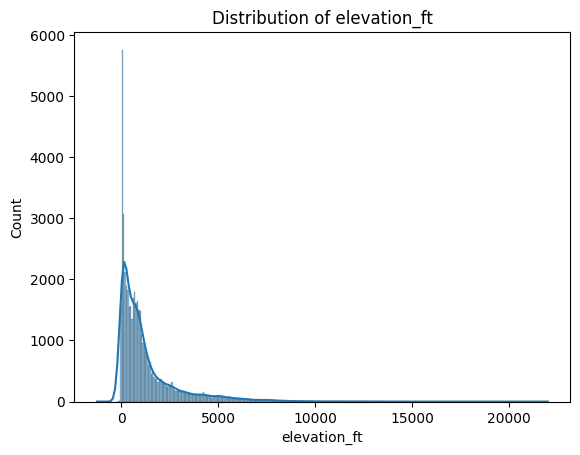

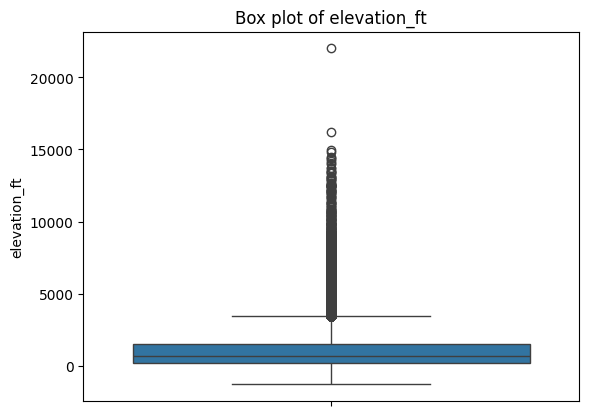

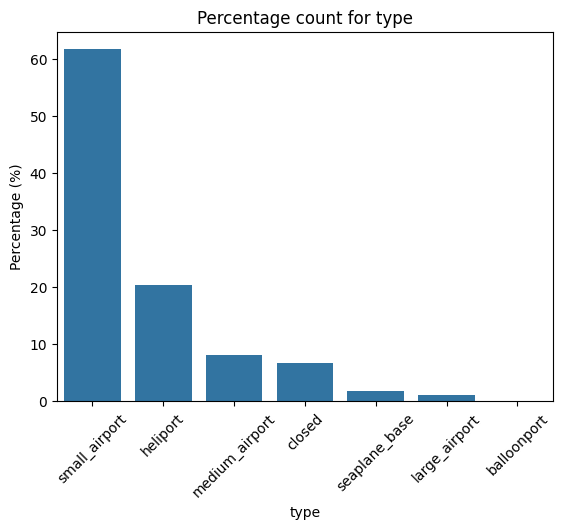

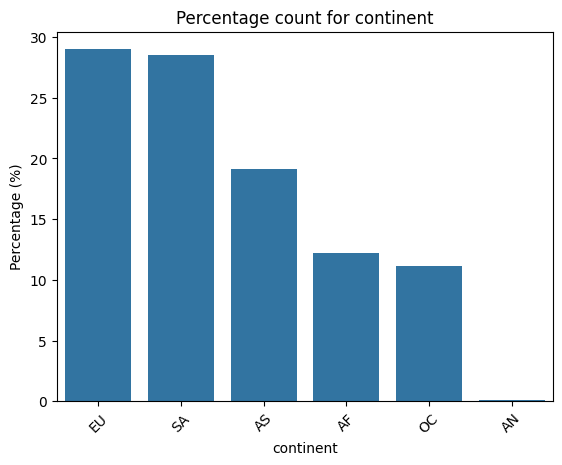

In [ ]:
#Perform Advanced EDA
advanced_eda(ac_df)

In [ ]:
#Since the airline intends to initiate 5 round trips between medium and large US airports, are there missing values for medium/large US airports?
#Define function to filter missing dataframe
def filter_missing_values(df):
    # Filter rows where country is 'US' and type is either 'medium_airport' or 'large_airport'
    filtered_df = df[(df['iso_country'] == 'US') & (df['type'].isin(['medium_airport', 'large_airport']))]

    # Print missing values in filtered DataFrame
    print("\nMissing Values:")
    print(filtered_df.isnull().sum())


#Run function to see if there medium/large US Airports with missing values.
filter_missing_values(ac_df)


Missing Values:
type              0
name              0
elevation_ft      3
continent       858
iso_country       0
municipality      3
iata_code        37
coordinates       0
dtype: int64


In [ ]:
"""
Key Findings from Airport Code Dataset Analysis

1. Dataset Overview
   - Shape of the dataset: (55369, 8)
   - 101 duplicate records were removed, resulting in a final shape of (55268, 8).

2. Data Cleaning
   - Column names were converted to lowercase.

3. Outlier and Distribution Analysis
   - Outliers, skewness, and distribution analysis are not applicable for this table.

4. Missing Values
   - Missing values exist in the following columns:
     - iata_code
     - continent
     - municipality
     - elevation_ft
     - iso_country

5. Airport Type
   - The majority of airports in the dataset are classified as small.
"""

'\nKey Findings from Airport Code Dataset Analysis\n\n1. Dataset Overview\n   - Shape of the dataset: (55369, 8)\n   - 101 duplicate records were removed, resulting in a final shape of (55268, 8).\n\n2. Data Cleaning\n   - Column names were converted to lowercase.\n\n3. Outlier and Distribution Analysis\n   - Outliers, skewness, and distribution analysis are not applicable for this table.\n\n4. Missing Values\n   - Missing values exist in the following columns:\n     - iata_code\n     - continent\n     - municipality\n     - elevation_ft\n     - iso_country\n\n5. Airport Type\n   - The majority of airports in the dataset are classified as small.\n'

Tickets Analysis

In [ ]:
#Let's import the Tickets.csv file into Python using Pandas as follows:
#Assuming tk_df is the DataFrame
tk_df = pd.read_csv(r'/content/drive/MyDrive/sample_data/Tickets.csv')

DataFrame Shape:
(1167285, 12)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167285 entries, 0 to 1167284
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ITIN_ID            1167285 non-null  int64  
 1   YEAR               1167285 non-null  int64  
 2   QUARTER            1167285 non-null  int64  
 3   ORIGIN             1167285 non-null  object 
 4   ORIGIN_COUNTRY     1167285 non-null  object 
 5   ORIGIN_STATE_ABR   1167285 non-null  object 
 6   ORIGIN_STATE_NM    1167285 non-null  object 
 7   ROUNDTRIP          1167285 non-null  float64
 8   REPORTING_CARRIER  1167285 non-null  object 
 9   PASSENGERS         1165308 non-null  float64
 10  ITIN_FARE          1166325 non-null  object 
 11  DESTINATION        1167285 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 106.9+ MB
None

DataFrame Description:
             ITIN_ID       YEAR    QUARTER   O

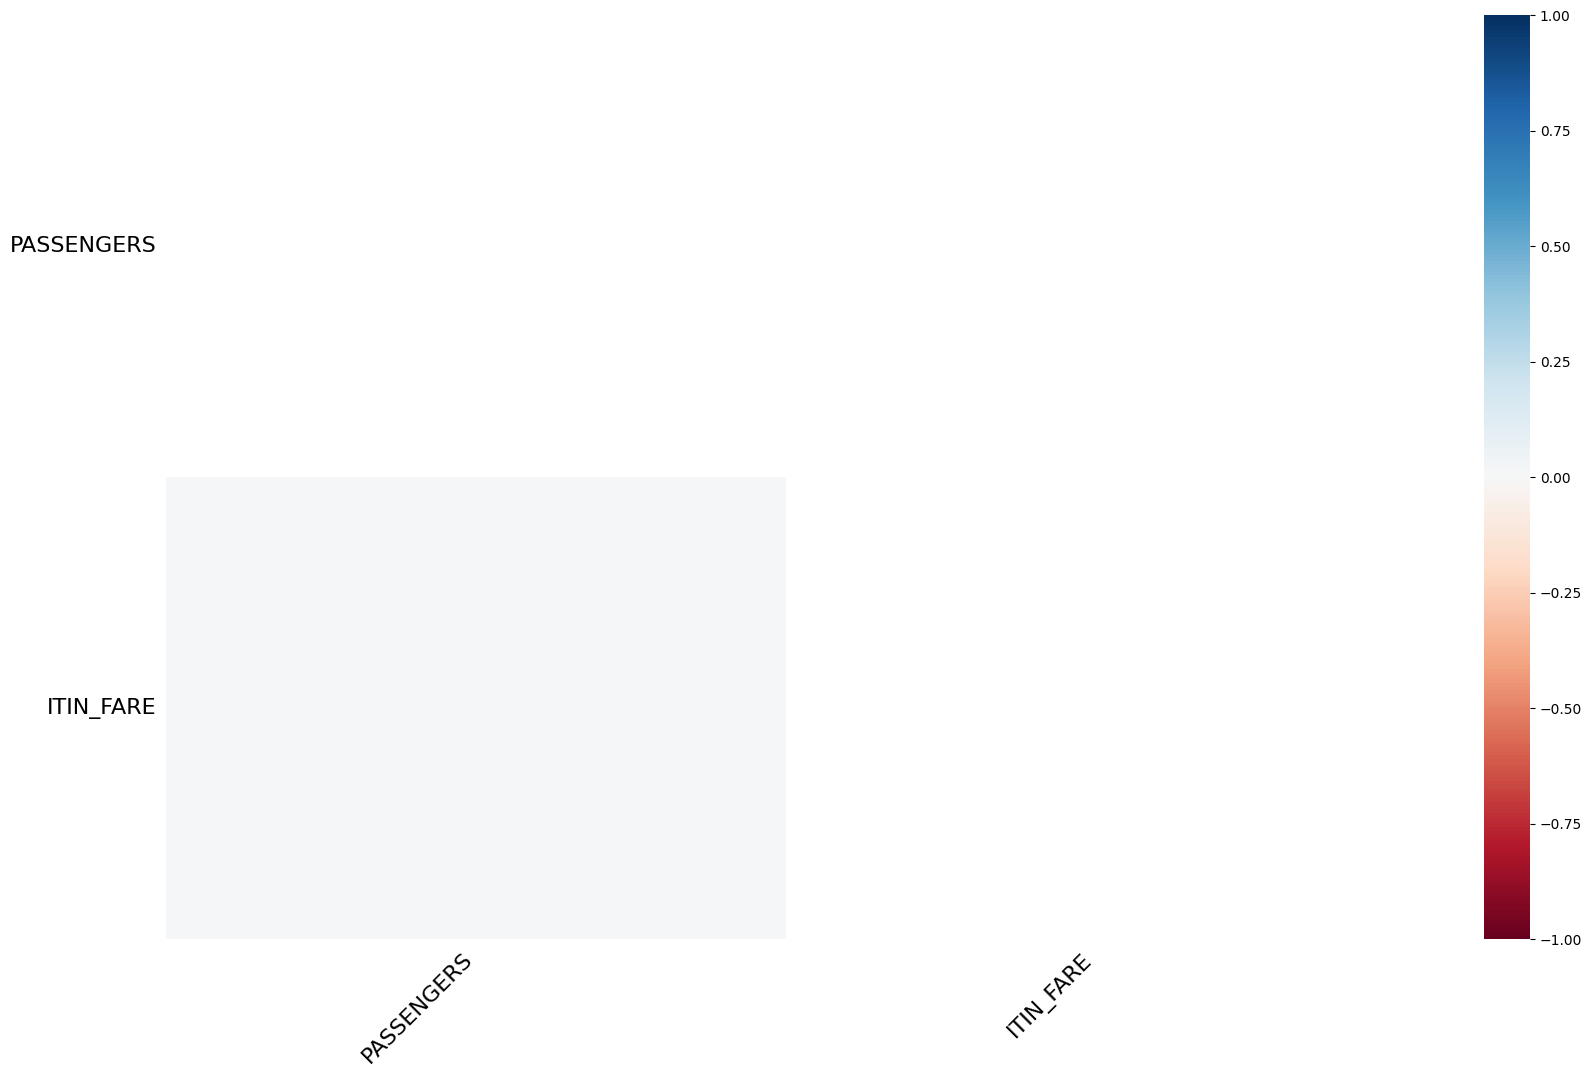

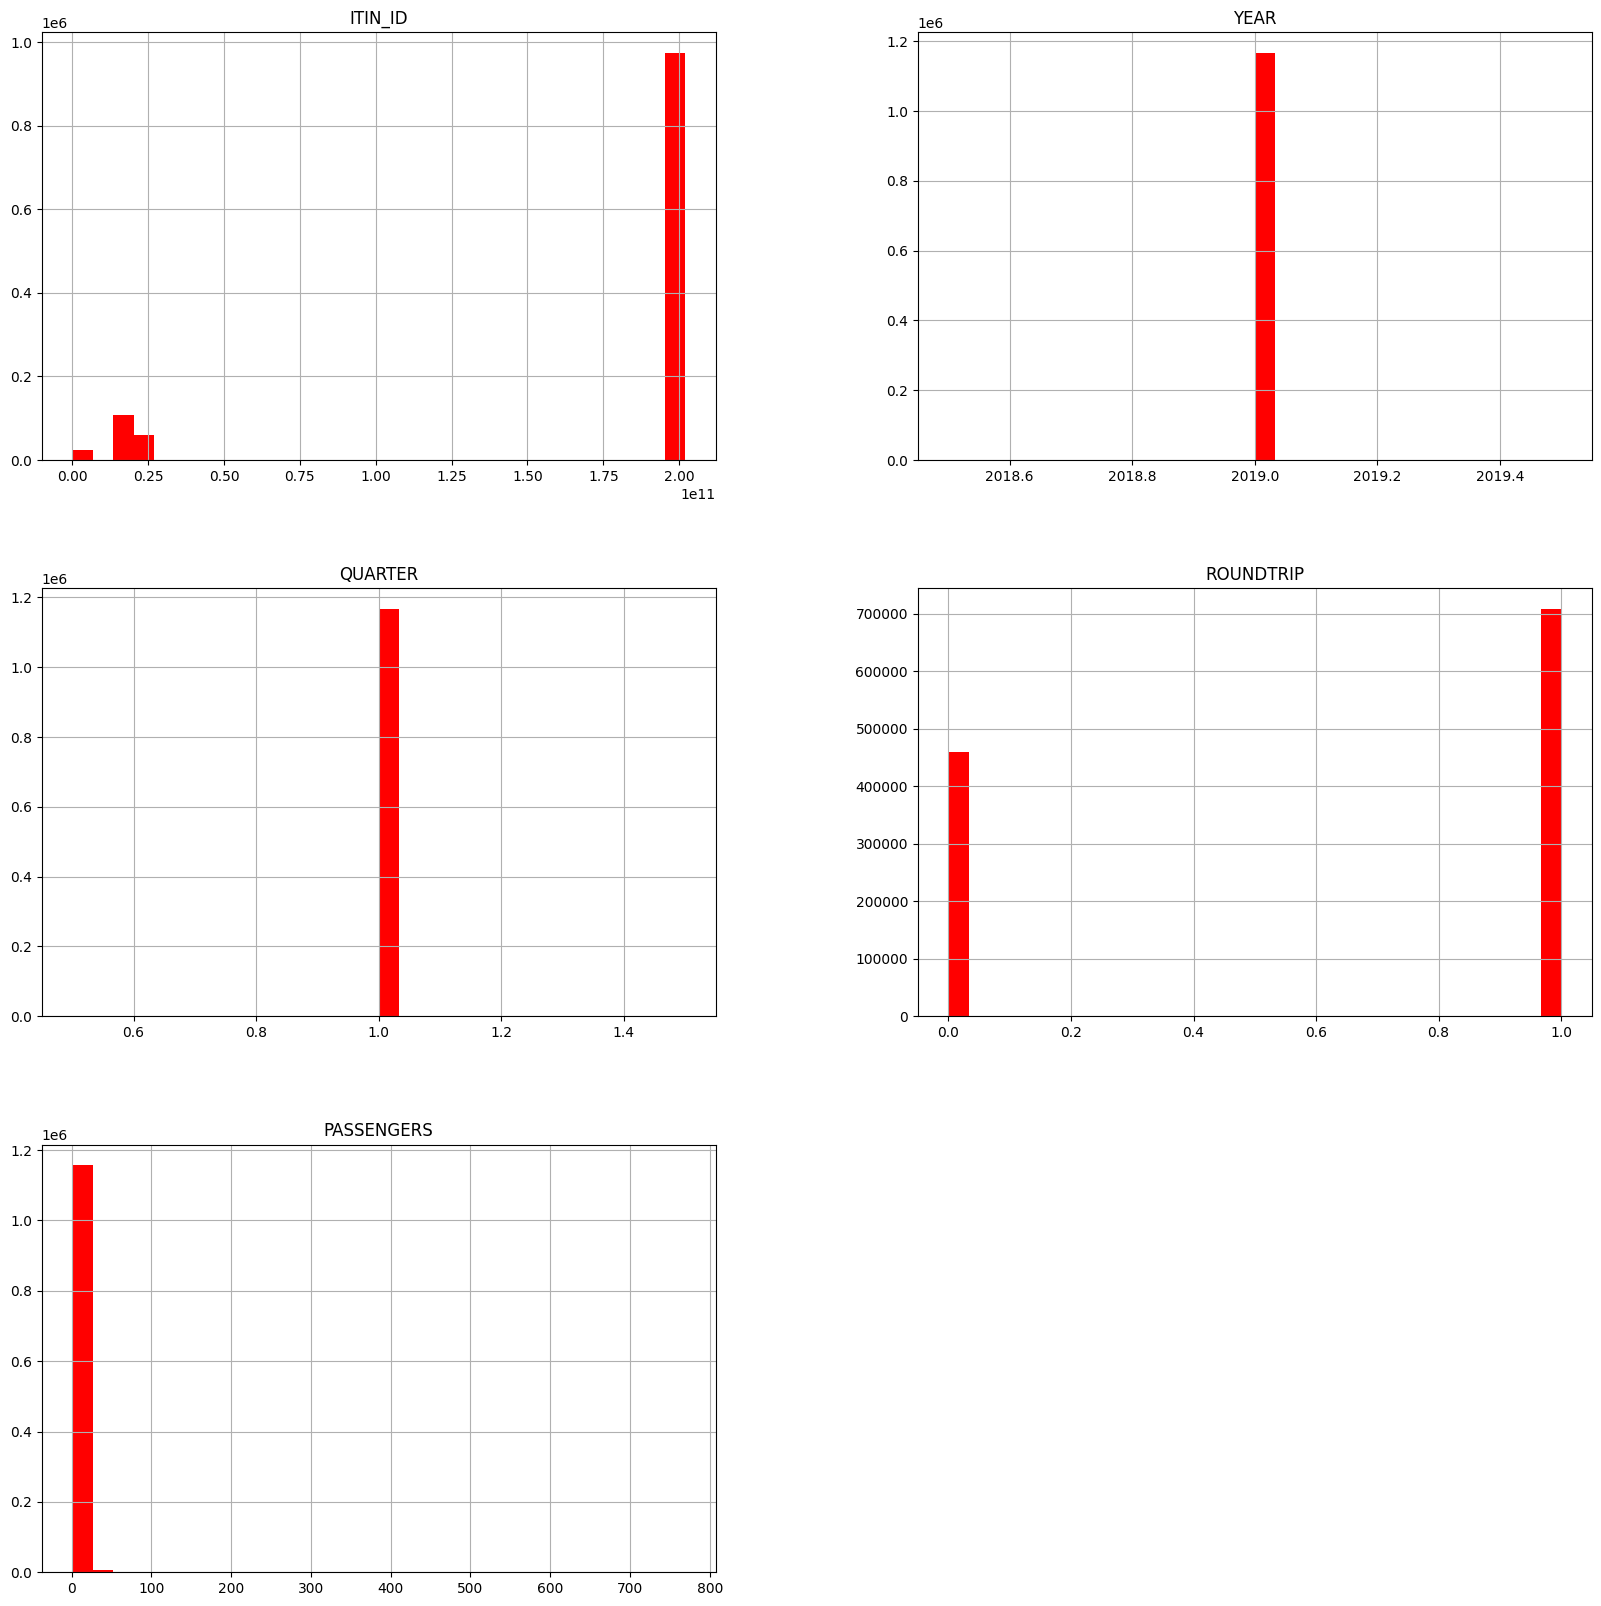


DataFrame Data Sample:
        ITIN_ID  YEAR  QUARTER ORIGIN ORIGIN_COUNTRY ORIGIN_STATE_ABR  \
0  201912723049  2019        1    ABI             US               TX   
1  201912723085  2019        1    ABI             US               TX   
2  201912723491  2019        1    ABI             US               TX   
3  201912723428  2019        1    ABI             US               TX   
4  201912723509  2019        1    ABI             US               TX   
5  201912723565  2019        1    ABI             US               TX   

  ORIGIN_STATE_NM  ROUNDTRIP REPORTING_CARRIER  PASSENGERS ITIN_FARE  \
0           Texas        1.0                MQ         1.0     736.0   
1           Texas        1.0                MQ         1.0     570.0   
2           Texas        1.0                MQ         1.0     564.0   
3           Texas        1.0                MQ         1.0     345.0   
4           Texas        0.0                MQ         1.0     309.0   
5           Texas        0.0    

In [ ]:
#Run quick EDA
quick_eda(tk_df)


In [ ]:
# Step 1: Convert column names to lowercase
tk_df.columns = tk_df.columns.str.lower()

# Step 2: Specify columns to clean
numeric_columns = ['itin_fare']

# Step 3: Clean the DataFrame and update hr_df directly
cleaning_info = clean_numeric_columns(tk_df, numeric_columns)


# Step 4: Display cleaning operations performed
print("\nCleaning Operations Performed:")
for column, info in cleaning_info.items():
    if column == 'duplicates':
        print(f"\n{info['operations'][0]}")
    else:
        print(f"\nColumn '{column}':")
        print(f"Total Rows Cleaned: {info['total_cleaned']}")
        for operation in info['operations']:
            print(f"- {operation}")


Cleaning Operations Performed:

Column 'itin_fare':
Total Rows Cleaned: 0
- Replaced NaN values with median: 346.0.

Removed 71898 duplicate rows.


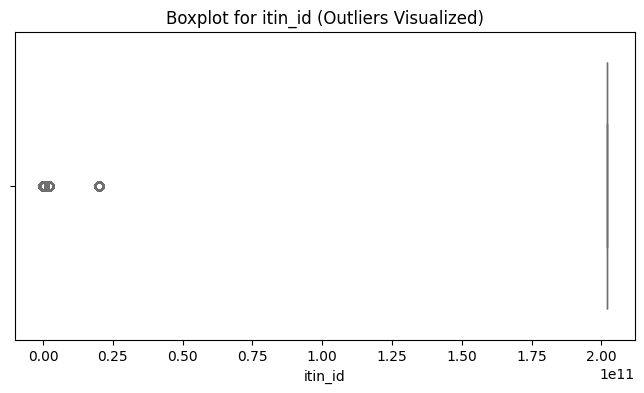

Outliers are present in column 'itin_id'


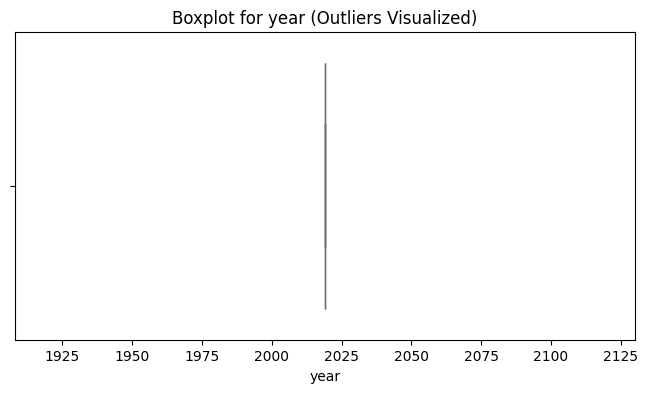

There are no outliers in column 'year'.


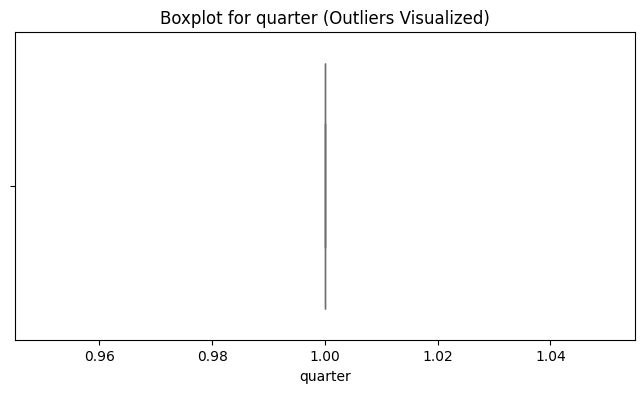

There are no outliers in column 'quarter'.


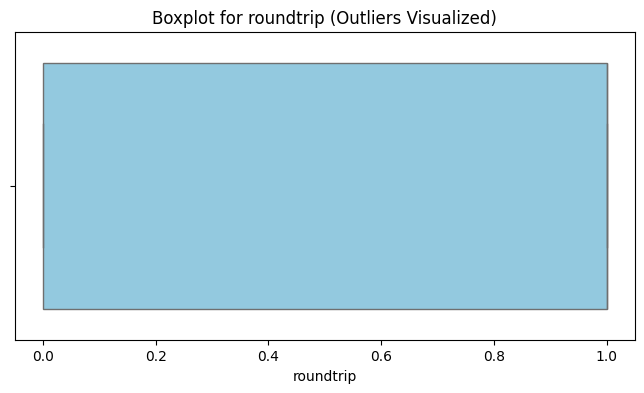

There are no outliers in column 'roundtrip'.


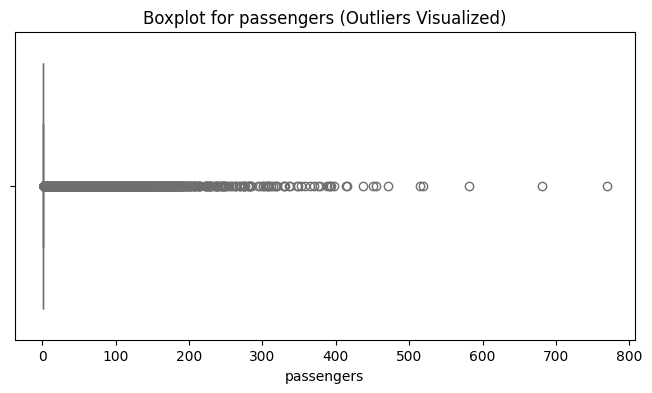

Outliers are present in column 'passengers'


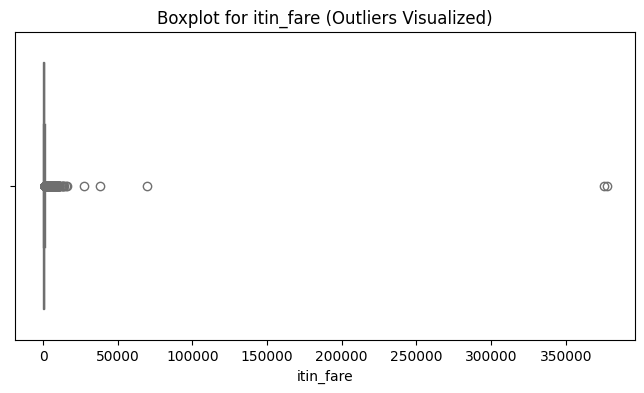

Outliers are present in column 'itin_fare'


In [ ]:
#Run function to check for outliers
find_outliers_boxplot(tk_df)

DataFrame Shape:
(1095387, 12)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1095387 entries, 0 to 1115070
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   itin_id            1095387 non-null  int64  
 1   year               1095387 non-null  int64  
 2   quarter            1095387 non-null  int64  
 3   origin             1095387 non-null  object 
 4   origin_country     1095387 non-null  object 
 5   origin_state_abr   1095387 non-null  object 
 6   origin_state_nm    1095387 non-null  object 
 7   roundtrip          1095387 non-null  float64
 8   reporting_carrier  1095387 non-null  object 
 9   passengers         1093812 non-null  float64
 10  itin_fare          1095387 non-null  float64
 11  destination        1095387 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 108.6+ MB
None

DataFrame Description:
             itin_id       year    quarter   origin

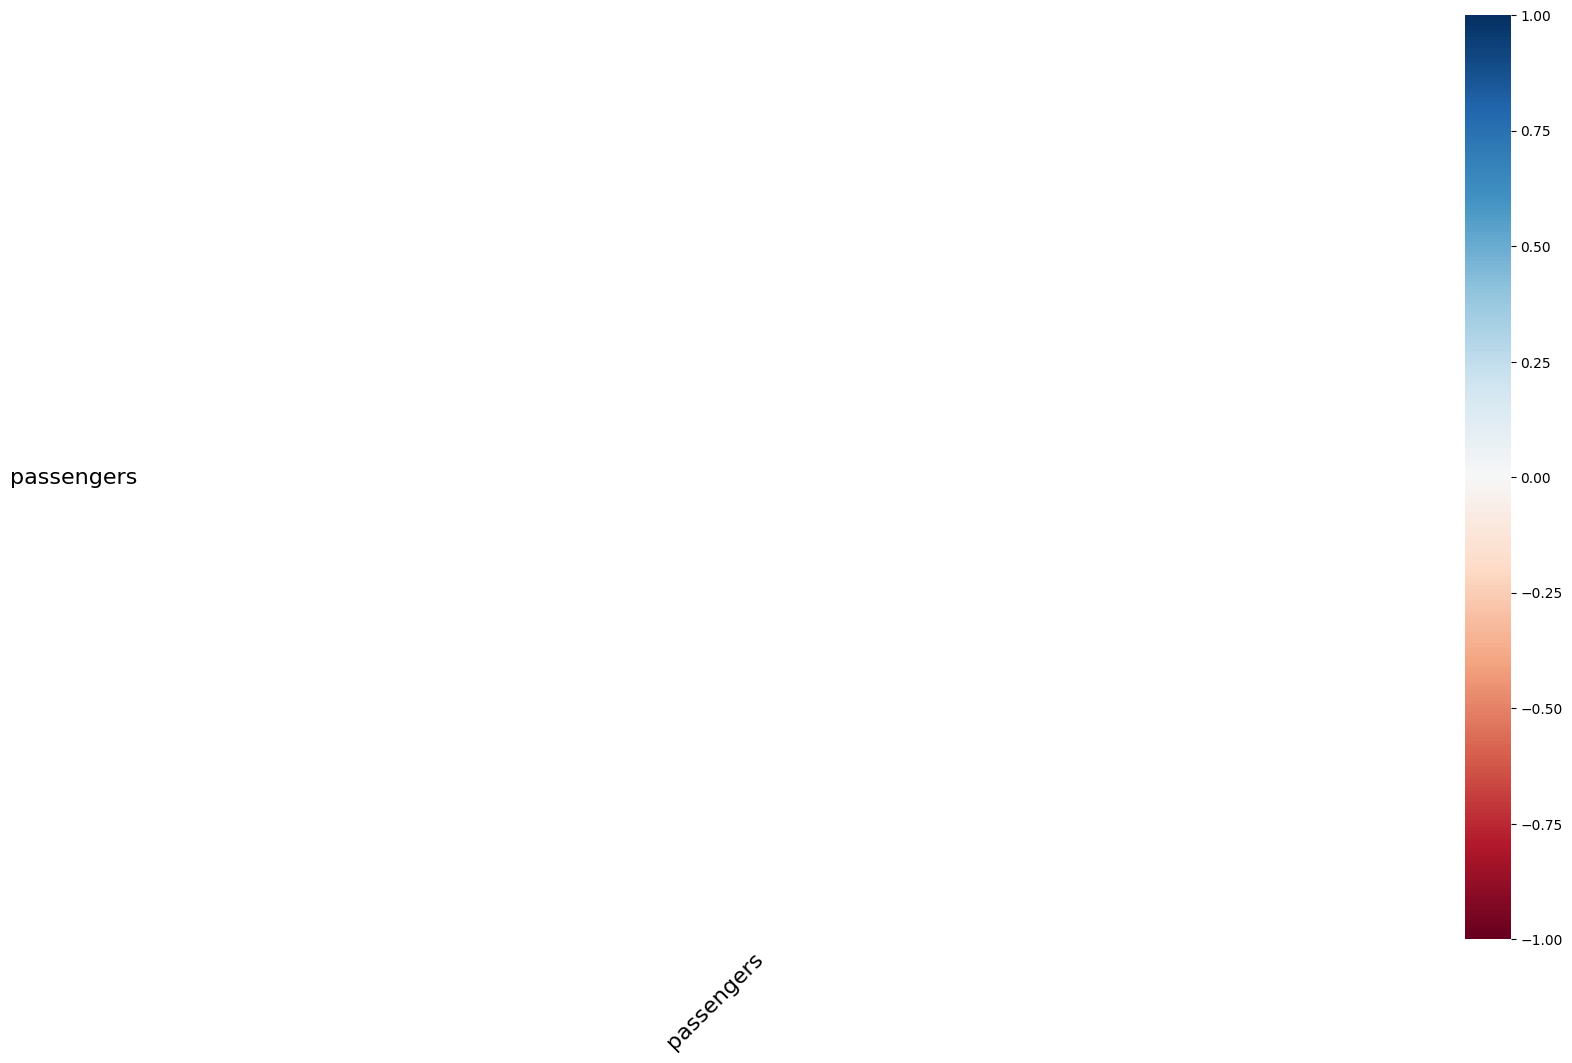

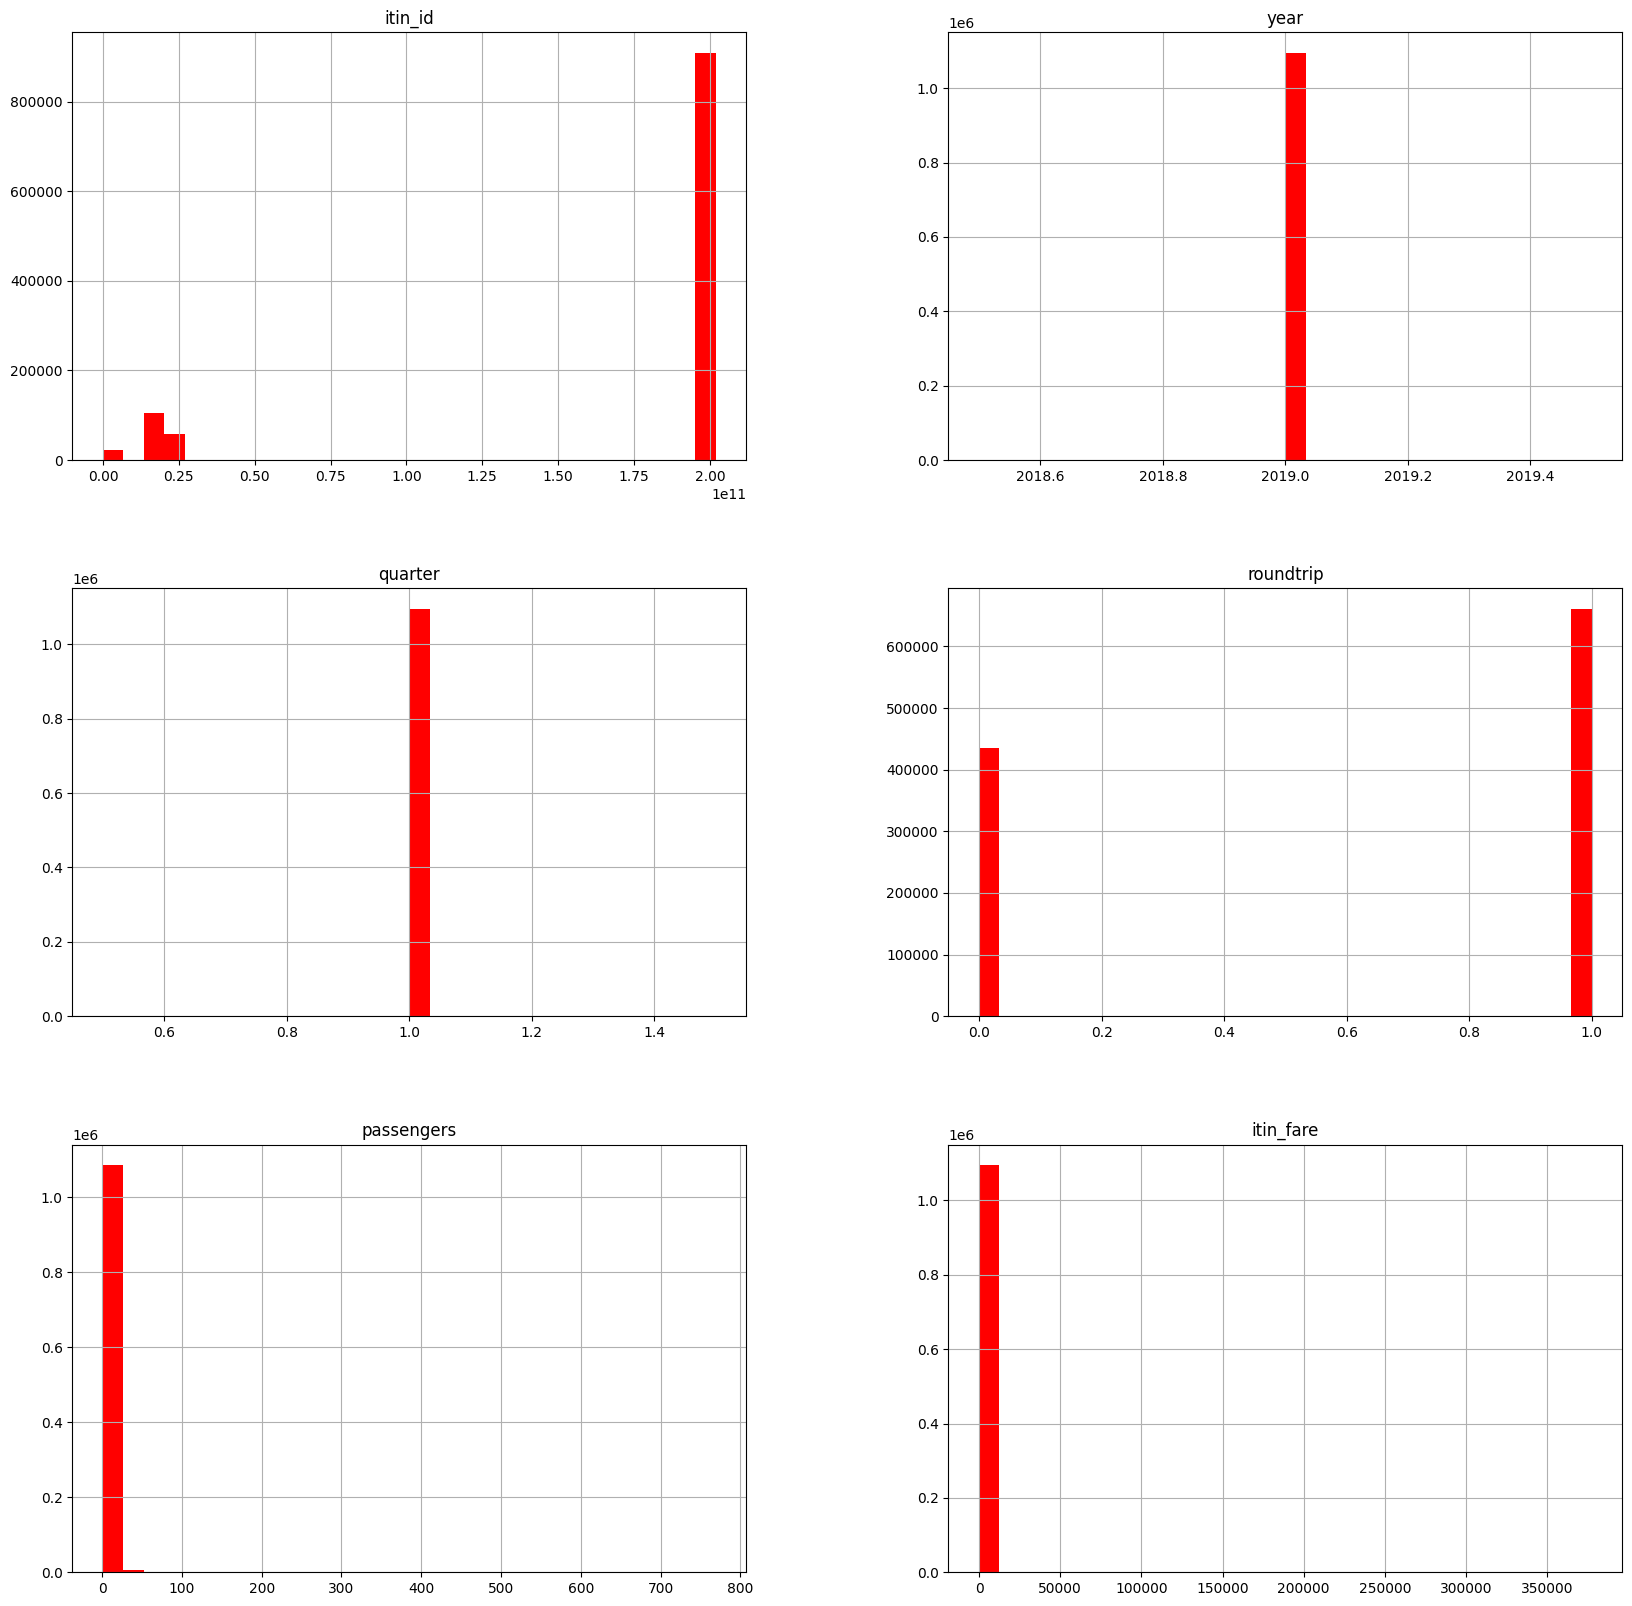


DataFrame Data Sample:
        itin_id  year  quarter origin origin_country origin_state_abr  \
0  201912723049  2019        1    ABI             US               TX   
1  201912723085  2019        1    ABI             US               TX   
2  201912723491  2019        1    ABI             US               TX   
3  201912723428  2019        1    ABI             US               TX   
4  201912723509  2019        1    ABI             US               TX   
5  201912723565  2019        1    ABI             US               TX   

  origin_state_nm  roundtrip reporting_carrier  passengers  itin_fare  \
0           Texas        1.0                MQ         1.0      736.0   
1           Texas        1.0                MQ         1.0      570.0   
2           Texas        1.0                MQ         1.0      564.0   
3           Texas        1.0                MQ         1.0      345.0   
4           Texas        0.0                MQ         1.0      309.0   
5           Texas        0

In [ ]:
#perform quick EDA
quick_eda(tk_df)

In [ ]:
"""
Key Findings from Tickets Data Analysis

1. Dataset Overview
   - Shape of the dataset: (1,167,285, 12)
   - 71,898 duplicate records were found and removed, resulting in a final shape of (1,095,387, 12).

2. Missing Values
   - Missing values were identified in the following columns:
     - passengers
     - itin_fare

3. Data Cleaning
   - Column names were converted to lowercase.

4. Data Types
   - Data types were adjusted to appropriate types after inspecting each column.

5. Outlier Analysis
   - Outliers exist in the following columns:
     - itin_fare
     - passengers

6. Distribution Analysis
   - The mean is greater than the median for the roundtrip and passengers columns, indicating that the data is right-skewed.
"""

'\nKey Findings from Tickets Data Analysis\n\n1. Dataset Overview\n   - Shape of the dataset: (1,167,285, 12)\n   - 71,898 duplicate records were found and removed, resulting in a final shape of (1,095,387, 12).\n\n2. Missing Values\n   - Missing values were identified in the following columns:\n     - passengers\n     - itin_fare\n\n3. Data Cleaning\n   - Column names were converted to lowercase.\n\n4. Data Types\n   - Data types were adjusted to appropriate types after inspecting each column.\n\n5. Outlier Analysis\n   - Outliers exist in the following columns:\n     - itin_fare\n     - passengers\n\n6. Distribution Analysis\n   - The mean is greater than the median for the roundtrip and passengers columns, indicating that the data is right-skewed.\n'

In [ ]:
# Print column list for each dataframe
print(hr_df.columns.tolist())
print(tk_df.columns.tolist())
print(ac_df.columns.tolist())

['fl_date', 'op_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id', 'destination', 'dest_city_name', 'dep_delay', 'arr_delay', 'cancelled', 'air_time', 'distance', 'occupancy_rate', 'status']
['itin_id', 'year', 'quarter', 'origin', 'origin_country', 'origin_state_abr', 'origin_state_nm', 'roundtrip', 'reporting_carrier', 'passengers', 'itin_fare', 'destination']
['type', 'name', 'elevation_ft', 'continent', 'iso_country', 'municipality', 'iata_code', 'coordinates']


DataFrame Shape:
(1855005, 17)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1855005 entries, 0 to 1910835
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   fl_date            datetime64[ns]
 1   op_carrier         object        
 2   tail_num           object        
 3   op_carrier_fl_num  object        
 4   origin_airport_id  int64         
 5   origin             object        
 6   origin_city_name   object        
 7   dest_airport_id    int64         
 8   destination        object        
 9   dest_city_name     object        
 10  dep_delay          float64       
 11  arr_delay          float64       
 12  cancelled          float64       
 13  air_time           float64       
 14  distance           float64       
 15  occupancy_rate     float64       
 16  status             object        
dtypes: datetime64[ns](1), float64(6), int64(2), object(8)
memory usage: 254.7+ MB
None

DataFrame Desc

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


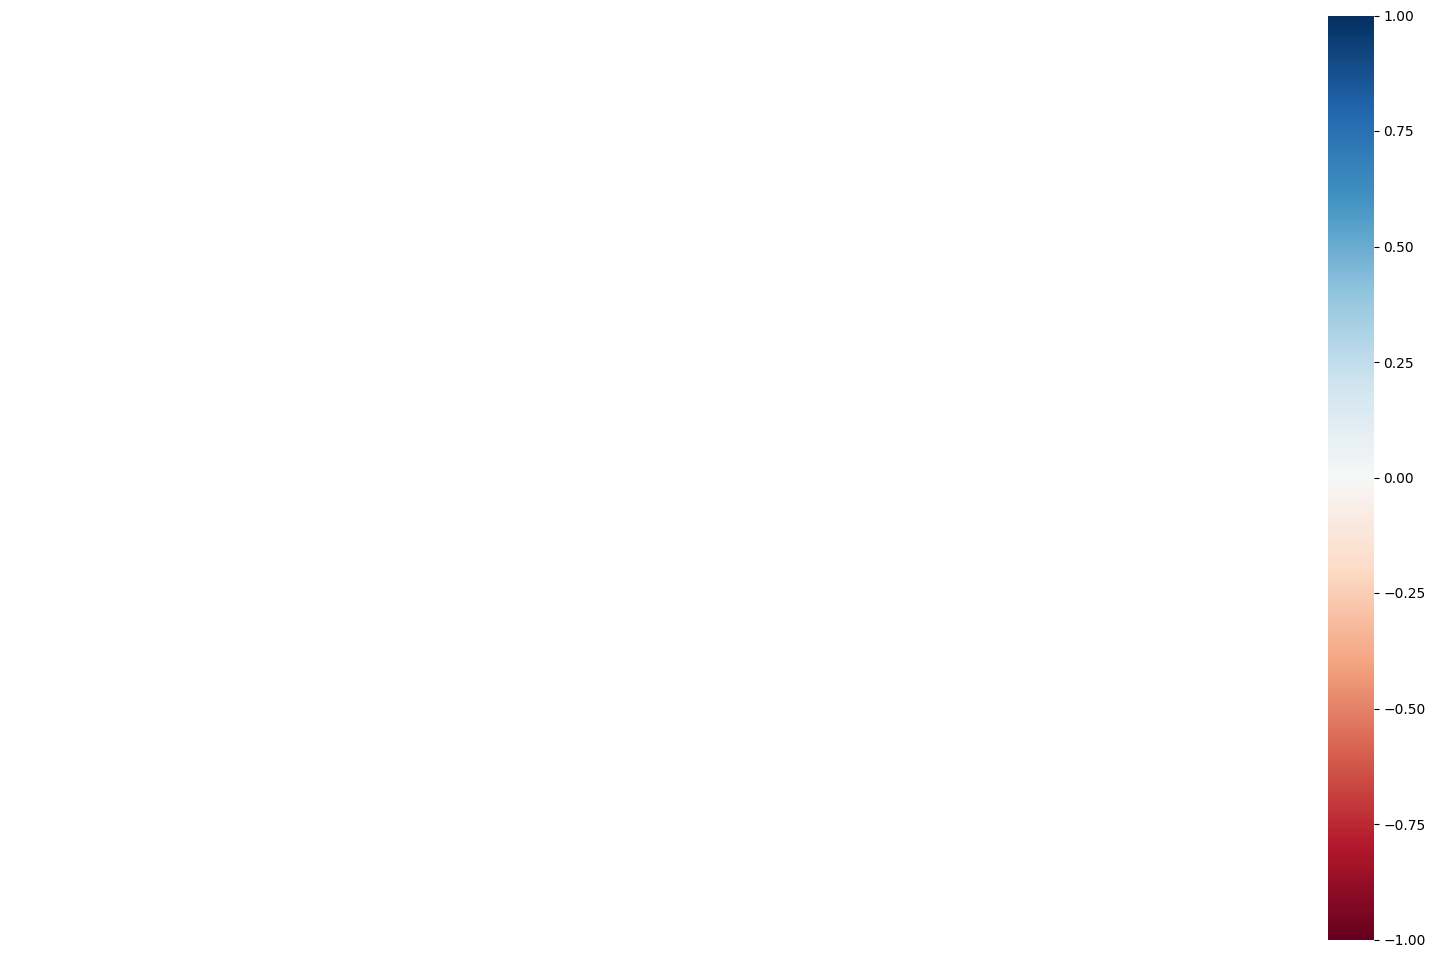

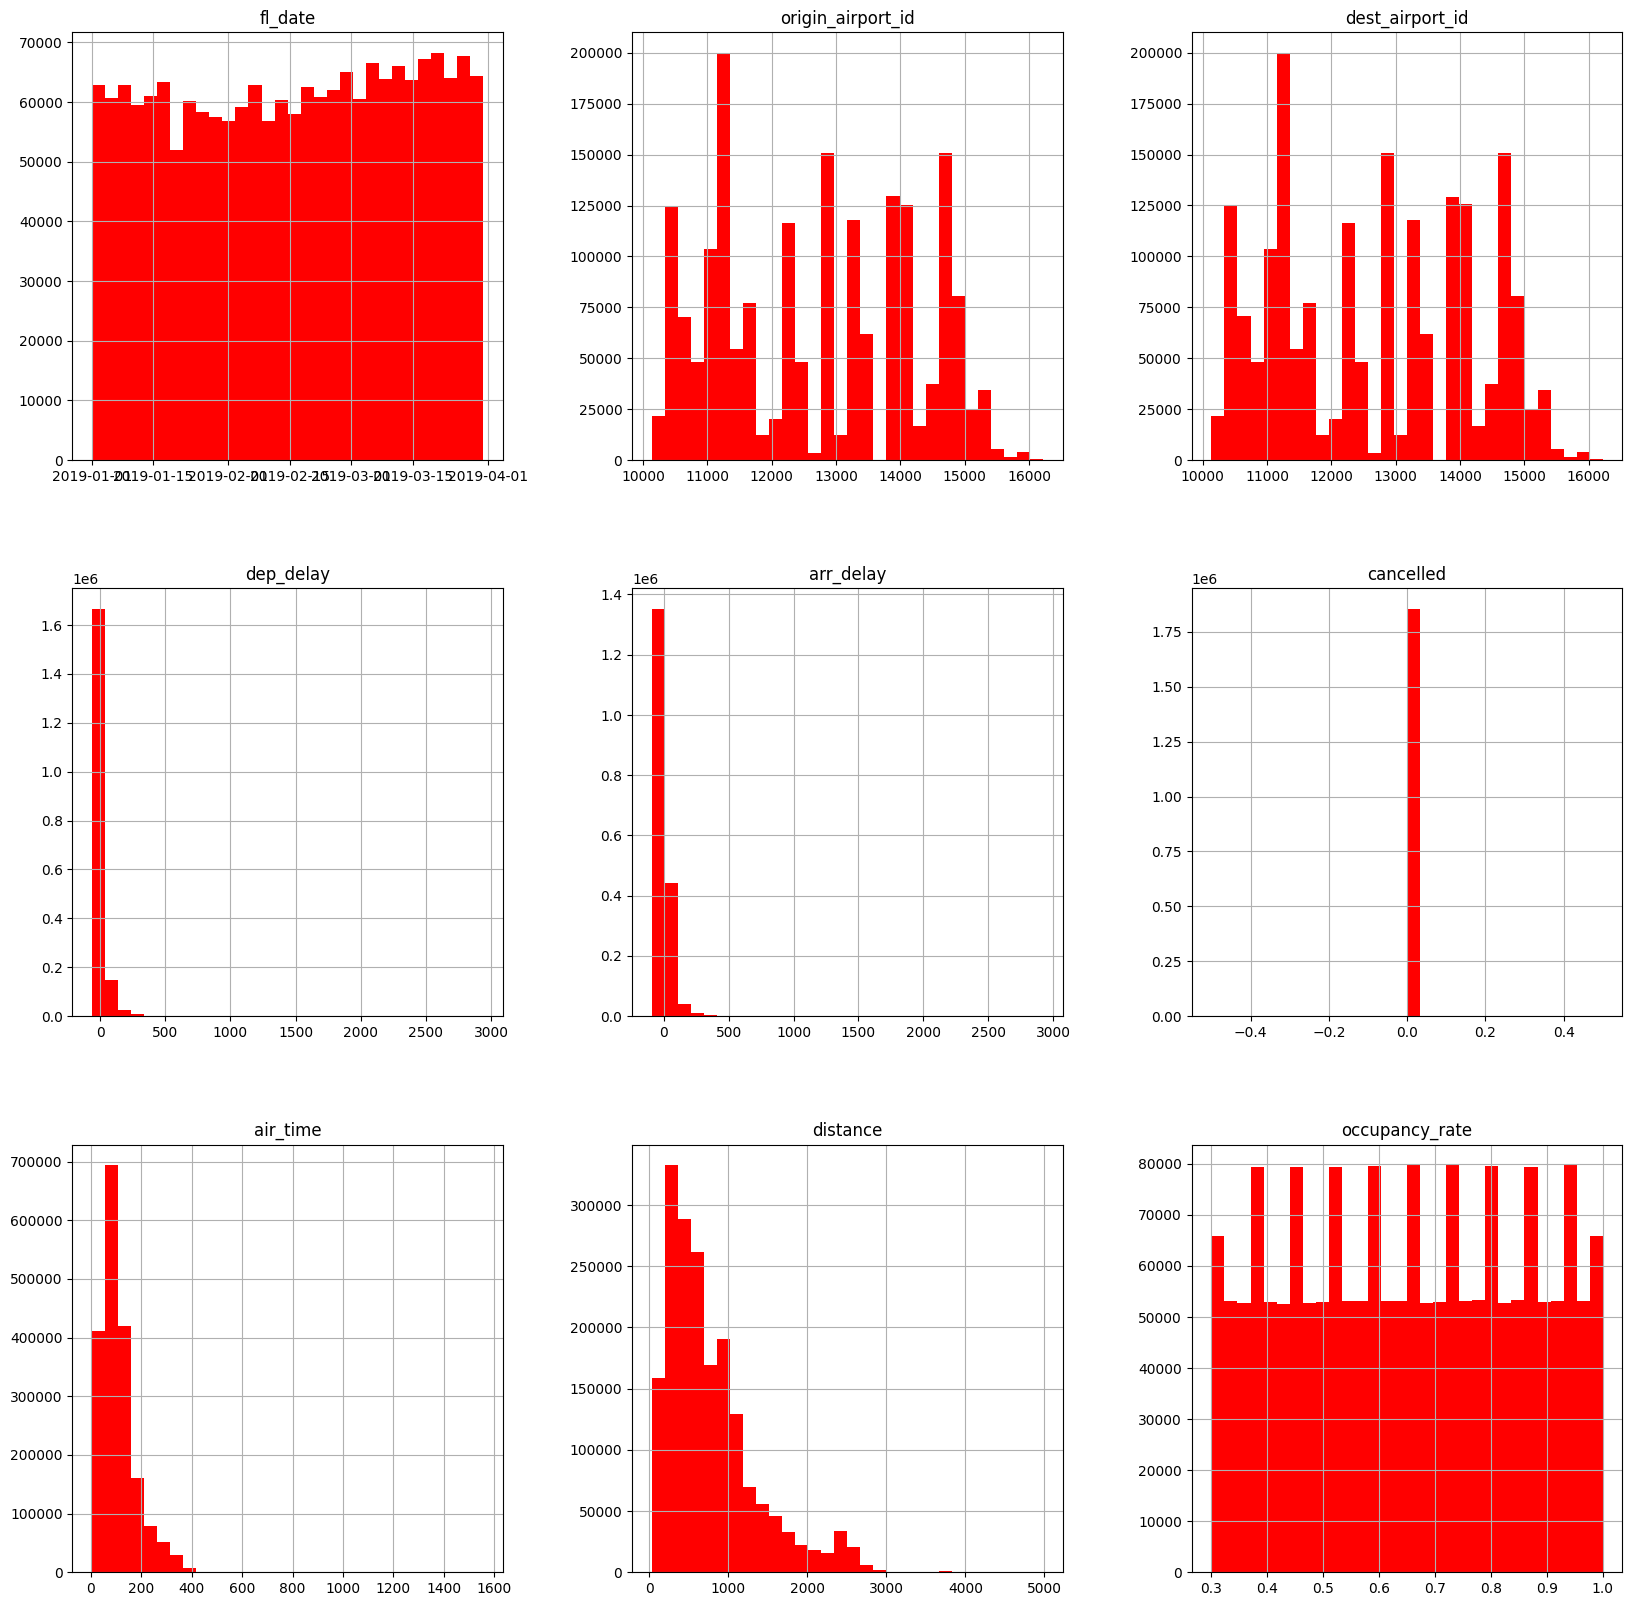


DataFrame Data Sample:
     fl_date op_carrier tail_num op_carrier_fl_num  origin_airport_id origin  \
0 2019-03-02         WN   N955WN              4591              14635    RSW   
1 2019-03-02         WN   N8686A              3231              14635    RSW   
2 2019-03-02         WN   N201LV              3383              14635    RSW   
3 2019-03-02         WN   N413WN              5498              14635    RSW   
4 2019-03-02         WN   N7832A              6933              14635    RSW   
5 2019-03-02         WN   N492WN              3960              14635    RSW   

  origin_city_name  dest_airport_id destination    dest_city_name  dep_delay  \
0   Fort Myers, FL            11042         CLE     Cleveland, OH       -8.0   
1   Fort Myers, FL            11066         CMH      Columbus, OH        1.0   
2   Fort Myers, FL            11066         CMH      Columbus, OH        0.0   
3   Fort Myers, FL            11066         CMH      Columbus, OH       11.0   
4   Fort Myers,

In [ ]:
hr_df = hr_df[hr_df[['op_carrier', 'fl_date', 'tail_num', 'origin', 'destination', 'dep_delay', 'arr_delay', 'air_time',
                     'distance', 'occupancy_rate']].notnull().all(axis=1) &
              (hr_df['cancelled'] == 0) &
              (hr_df['air_time'] > 0) &
              (hr_df['distance'] > 0)]
quick_eda(hr_df)

Filter, Join, and Merge DataFrames

In [ ]:
"""
Filter Conditions:

1. hr_df DataFrame:
   - The following columns must not be null: op_carrier, tail_num, origin, destination, dep_delay, arr_delay, air_time, distance, and occupancy_rate
   - Flight must not be cancelled (cancelled = 0), and air_time must be greater than 0 and distance must be greater than 0

2. ac_df DataFrame:
   - iso_country must be 'US'
   - type must be either 'medium_airport' or 'large_airport'
   - iata_code must not be null

3. tk_df DataFrame:
   - Itin_id must not be null
   - roundtrip must be 1 (indicating roundtrip flights)
   - reporting_carrier must not be null
   - Passengers must not be null
   - Itin_fare must be not null and greater than 0
"""

"\nFilter Conditions:\n\n1. hr_df DataFrame:\n   - The following columns must not be null: op_carrier, tail_num, origin, destination, dep_delay, arr_delay, air_time, distance, and occupancy_rate\n   - Flight must not be cancelled (cancelled = 0), and air_time must be greater than 0 and distance must be greater than 0\n\n2. ac_df DataFrame:\n   - iso_country must be 'US'\n   - type must be either 'medium_airport' or 'large_airport'\n   - iata_code must not be null\n\n3. tk_df DataFrame:\n   - Itin_id must not be null\n   - roundtrip must be 1 (indicating roundtrip flights)\n   - reporting_carrier must not be null\n   - Passengers must not be null\n   - Itin_fare must be not null and greater than 0\n"

In [ ]:

# Filter ac_df
ac_df = ac_df[(ac_df['iso_country'] == 'US') &
              (ac_df['type'].isin(['medium_airport', 'large_airport'])) &
              (ac_df['iata_code'].notnull())]

# Filter tk_df
tk_df = tk_df[(tk_df['itin_id'].notnull()) &
              (tk_df['roundtrip'] == 1) &
              (tk_df[['reporting_carrier', 'passengers', 'itin_fare']].notnull().all(axis=1)) &
              (tk_df['itin_fare'] > 0)]

# Filter hr_df
hr_df = hr_df[hr_df[['op_carrier', 'fl_date', 'tail_num', 'origin', 'destination', 'dep_delay', 'arr_delay', 'air_time',
                     'distance', 'occupancy_rate']].notnull().all(axis=1) &
              (hr_df['cancelled'] == 0) &
              (hr_df['air_time'] > 0) &
              (hr_df['distance'] > 0)]

#After applying the filters, we need to provide solutions to the 5 key questions.
#As noted in the question, we are only interested in the number of round trip flights and routes.
#Hence, we are creating merge keys origin and destination in both the Ticket and Flights table

tk_df['merge_key'] = tk_df['origin'] + '_' + tk_df['destination']
hr_df['merge_key'] = hr_df['origin'] + '_' + hr_df['destination']



Question 1: Top 10 Busiest Round Trip Routes (Based on Flights)

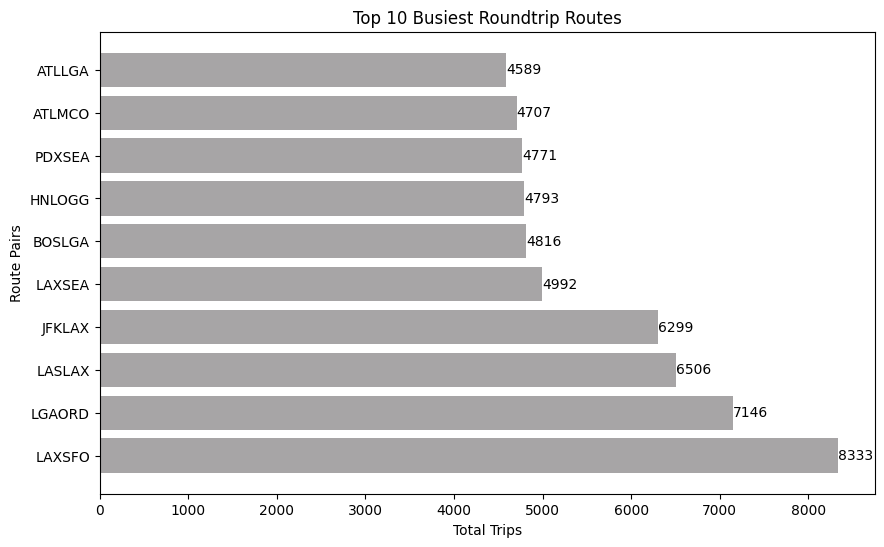

   route_pair  trip_total
0      LAXSFO        8333
2      LGAORD        7146
4      LASLAX        6506
6      JFKLAX        6299
8      LAXSEA        4992
10     BOSLGA        4816
12     HNLOGG        4793
13     PDXSEA        4771
16     ATLMCO        4707
18     ATLLGA        4589


In [ ]:
# Tickets can't be used to determine occupancy.
# Additionally, canceled flights should be excluded

def get_top_n_routes(hr_df, n):
    # Group by merge_key, origin, and destination, count occurrences, and sort
    top_routes = hr_df.groupby(['merge_key', 'origin', 'destination']).size().reset_index(name='cnt')
    top_routes = top_routes.sort_values(by='cnt', ascending=False).head(n * 2)

    # Self-join to find round-trip pairs
    round_trip = pd.merge(top_routes, top_routes, left_on=['origin', 'destination'], right_on=['destination', 'origin'])

    # Create unique route identifier by sorting origin and destination
    round_trip['route_pair'] = round_trip.apply(lambda row: ''.join(sorted([row['origin_x'], row['destination_x']])), axis=1)

    # Calculate total trips for each route pair and get distinct routes
    round_trip['trip_total'] = round_trip['cnt_x'] + round_trip['cnt_y']

    # Get distinct routes with total trips
    distinct_routes = round_trip[['route_pair', 'trip_total']].drop_duplicates()

    # Plotting the results
    plt.figure(figsize=(10, 6))
    bars = plt.barh(distinct_routes['route_pair'], distinct_routes['trip_total'], color='#A7A5A6')

    # Adding labels and title
    plt.xlabel('Total Trips')
    plt.ylabel('Route Pairs')
    plt.title(f'Top {n} Busiest Roundtrip Routes')

    # Adding values to each bin
    for bar in bars:
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
                 f'{bar.get_width():.0f}', va='center')

    # Show the plot
    plt.show()

    return distinct_routes

# Example usage
n = 10  # Change this to get a different number of top routes
distinct_routes = get_top_n_routes(hr_df, n)
print(distinct_routes)

Question 2: Top 10 most profitable Round Trip Routes (Without Considering Upfront Airplane Cost

In [ ]:
'''
Key Assumptions
Gross Profit = Revenue - Cost
Cost = (8+1.18)*distance + origin_airport_size_cost(5000 medium/10,000 large) + origin_airport_size_cost(5000 medium/10,000 large)
        + 0 if dep_delay<=15 else (dep_delay-15)*75 + 0 if arr_delay<=15 else (arr_delay-15*75)
Since itin_fare is the itinerary cost per passenger,
Revenue  = average_itin_fare per round trip route * occupants + 50% * occupants*$70
where occupants = 200*occupancy_rate
'''

# Step 1: Calculate average fare from tk_df grouped by merge_key
average_fare_df = (
    tk_df.groupby('merge_key')
    .agg(average_fare=('itin_fare', 'mean'))  # Calculate average fare
    .reset_index()  # Reset index to turn the grouped data back into a DataFrame
)

# Step 2: Merging the DataFrames
hta_df = (
    hr_df.merge(average_fare_df, on='merge_key', how='left')  # Left join with average fare DataFrame
    .merge(ac_df.rename(columns={'iata_code': 'origin', 'type': 'origin_size'}),
           left_on='origin', right_on='origin', how='left')  # Merge for origin size
    .merge(ac_df.rename(columns={'iata_code': 'destination', 'type': 'destination_size'}),
           left_on='destination', right_on='destination', how='left')  # Merge for destination size
)

# Step 3: Calculating the required columns and aggregating
hta_df = (
    hta_df.groupby(['merge_key', 'origin', 'destination'])  # Grouping by merge_key, origin, and destination
    .agg(
        origin_size=('origin_size', 'first'),  # Get the first origin size
        destination_size=('destination_size', 'first'),  # Get the first destination size
        avg_dep_delay=('dep_delay', 'mean'),  # Average departure delay
        avg_arr_delay=('arr_delay', 'mean'),  # Average arrival delay
        avg_distance=('distance', 'mean'),  # Average distance
        occupants=('occupancy_rate', lambda x: (x * 200).mean()),  # Average number of occupants
        average_fare=('average_fare', 'mean')  # Average fare from the joined DataFrame
    )
    .reset_index()  # Reset index to convert groupby object back to DataFrame
)


# Display the resulting DataFrame
print(hta_df.shape)


(5907, 10)


In [ ]:
'''
origin_size - The airport size based on the origin_type (5000 for medium airports, 10000 for large airports, 0 for others).
destination_size - The airport size based on the destination_type (5000 for medium airports, 10000 for large airports, 0 for others).
avg_dep_delay - The average departure delay for each grouping.
avg_arr_delay - The average arrival delay for each grouping.
avg_distance - The average flight distance for each grouping.
occupants - The estimated number of occupants per flight, calculated as occupancy_rate * 200.
average_fare - The average fare, derived from tk_df and joined based on merge_key and reporting_carrier.
carrier_flight_count - The count of flights for each carrier in the grouping
'''

# Calculating average fare by merge_key and reporting_carrier
average_fare_df = tk_df.groupby(['merge_key', 'reporting_carrier'], as_index=False).agg(average_fare=('itin_fare', 'mean'))

# Joining hr_df with the average_fare_df on merge_key and op_carrier/reporting_carrier
merged_df = pd.merge(hr_df, average_fare_df, left_on=['merge_key', 'op_carrier'], right_on=['merge_key', 'reporting_carrier'], how='left')

# Joining ac_df twice for origin and destination to get the airport sizes
merged_df = pd.merge(merged_df, ac_df[['type', 'iata_code']], left_on='origin', right_on='iata_code', how='left').rename(columns={'type': 'origin_type'}).drop(columns='iata_code')
merged_df = pd.merge(merged_df, ac_df[['type', 'iata_code']], left_on='destination', right_on='iata_code', how='left').rename(columns={'type': 'destination_type'}).drop(columns='iata_code')

# Defining origin and destination sizes based on airport types
merged_df['origin_size'] = merged_df['origin_type'].apply(lambda x: 5000 if x == 'medium_airport' else 10000 if x == 'large_airport' else 0)
merged_df['destination_size'] = merged_df['destination_type'].apply(lambda x: 5000 if x == 'medium_airport' else 10000 if x == 'large_airport' else 0)

# Calculating averages and other aggregations
hta_df = merged_df.groupby(['merge_key', 'origin', 'destination', 'op_carrier'], as_index=False).agg(
    origin_size=('origin_size', 'first'),
    destination_size=('destination_size', 'first'),
    avg_dep_delay=('dep_delay', 'mean'),
    avg_arr_delay=('arr_delay', 'mean'),
    avg_distance=('distance', 'mean'),
    occupants=('occupancy_rate', lambda x: x.mean() * 200),
    average_fare=('average_fare', 'first'),
    carrier_flight_count=('op_carrier', 'size')
)

# Display the resulting dataframe
print(hta_df.shape)

(12034, 12)


In [ ]:


# Constants for calculations
DISTANCE_COST_RATE = 9.18
DELAY_COST_RATE = 75
OCCUPANTS_ADJUSTMENT_FACTOR = 0.5
OCCUPANTS_EXTRA_COST = 70
DELAY_THRESHOLD = 15

# Calculate cost and revenue for each row
hta_df['cost'] = (
    (DISTANCE_COST_RATE * hta_df['avg_distance']) +
    hta_df['origin_size'] +
    hta_df['destination_size'] +
    np.where(hta_df['avg_dep_delay'] <= DELAY_THRESHOLD, 0, (hta_df['avg_dep_delay'] - DELAY_THRESHOLD) * DELAY_COST_RATE) +
    np.where(hta_df['avg_arr_delay'] <= DELAY_THRESHOLD, 0, (hta_df['avg_arr_delay'] - DELAY_THRESHOLD) * DELAY_COST_RATE)
)

hta_df['revenue'] = hta_df['average_fare'] * hta_df['occupants'] + OCCUPANTS_ADJUSTMENT_FACTOR * hta_df['occupants'] * OCCUPANTS_EXTRA_COST

# Group by 'merge_key', 'origin', 'destination' and calculate aggregated values
hta_aggregated = hta_df.groupby(['merge_key', 'origin', 'destination'], as_index=False).agg(
    total_cost=('cost', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_oneway_flights=('carrier_flight_count', 'mean')
)

# Calculate profit as the difference between total revenue and total cost
hta_aggregated['profit'] = hta_aggregated['total_revenue'] - hta_aggregated['total_cost']

# Display the resulting dataframe
hta_aggregated

merge_key origin destination     total_cost  total_revenue  \
0      ABE_ATL    ABE         ATL   42705.120000   1.340567e+05   
1      ABE_CLT    ABE         CLT   19415.580000   7.458327e+04   
2      ABE_DTW    ABE         DTW   37881.036437   6.434918e+04   
3      ABE_FLL    ABE         FLL   24556.380000   2.359665e+04   
4      ABE_ORD    ABE         ORD   64031.037049   1.613035e+05   
5      ABE_PGD    ABE         PGD   14345.240000   3.052134e+04   
6      ABE_PHL    ABE         PHL   15504.900000   0.000000e+00   
7      ABE_PIE    ABE         PIE   18904.600000   3.126477e+04   
8      ABE_SFB    ABE         SFB   23096.760000   3.338617e+04   
9      ABI_DFW    ABI         DFW   16450.440000   5.587837e+04   
10     ABQ_ATL    ABQ         ATL   31649.420000   6.882432e+04   
11     ABQ_AUS    ABQ         AUS   51364.840000   6.426117e+04   
12     ABQ_BWI    ABQ         BWI   35330.600000   6.735592e+04   
13     ABQ_DAL    ABQ         DAL   25324.400000   5.758057e+04   
14     ABQ_DEN    ABQ         DEN  139711.920000   2.305072e+05   
15     ABQ_DFW    ABQ         DFW   50446.840000   1.350759e+05   
16     ABQ_HOU    ABQ         HOU   26967.620000   6.247716e+04   
17     ABQ_IAH    ABQ         IAH  134149.600000   2.974742e+05   
18     ABQ_JFK    ABQ         JFK   37076.430000   4.243134e+04   
19     ABQ_LAS    ABQ         LAS   48922.960000   6.653658e+04   
20     ABQ_LAX    ABQ         LAX   78644.580000   1.475853e+05   
21     ABQ_MCI    ABQ         MCI   26591.240000   6.458311e+04   
22     ABQ_MCO    ABQ         MCO   34256.540000   2.307055e+04   
23     ABQ_MDW    ABQ         MDW   30290.780000   5.843573e+04   
24     ABQ_MSP    ABQ         MSP   29755.580000   9.781067e+04   
25     ABQ_OAK    ABQ         OAK   28161.020000   5.594444e+04   
26     ABQ_ORD    ABQ         ORD  186760.035472   4.376312e+05   
27     ABQ_PDX    ABQ         PDX   60397.960000   9.008596e+04   
28     ABQ_PHX    ABQ         PHX   69033.120000   1.310144e+05   
29     ABQ_SAN    ABQ         SAN   77295.120000   7.757642e+04   
30     ABQ_SEA    ABQ         SEA   61664.800000   8.882772e+04   
31     ABQ_SFO    ABQ         SFO   58707.034820   1.503730e+05   
32     ABQ_SJC    ABQ         SJC   29341.957143   4.250148e+04   
33     ABQ_SLC    ABQ         SLC   73997.542581   1.684094e+05   
34     ABQ_SNA    ABQ         SNA   26554.500000   2.671067e+04   
35     ABR_MSP    ABR         MSP   17610.730588   4.657211e+04   
36     ABY_ATL    ABY         ATL   16331.100000   4.949177e+04   
37     ACT_DFW    ACT         DFW   15817.020000   4.110342e+04   
38     ACV_LAX    ACV         LAX   22394.273793   6.635043e+04   
39     ACV_SFO    ACV         SFO   19899.133065   6.740481e+04   
40     ACY_FLL    ACY         FLL   23968.860000   2.632758e+04   
41     ACY_MCO    ACY         MCO   22821.360000   2.314618e+04   
42     ACY_MYR    ACY         MYR   14277.880000   1.375736e+04   
43     ACY_PBI    ACY         PBI   23592.480000   1.922958e+04   
44     ACY_RSW    ACY         RSW   24014.760000   2.212465e+04   
45     ACY_TPA    ACY         TPA   23381.340000   2.167356e+04   
46     ADK_ANC    ADK         ANC   25942.560000   1.239752e+05   
47     ADQ_ANC    ADQ         ANC   17322.540000   4.763086e+04   
48     AEX_ATL    AEX         ATL   39930.000000   1.076259e+05   
49     AEX_DFW    AEX         DFW   17616.300000   7.334546e+04   
50     AEX_IAH    AEX         IAH   16744.200000   7.280343e+04   
51     AGS_ATL    AGS         ATL   63938.220000   8.480162e+04   
52     AGS_CLT    AGS         CLT   42570.400000   5.931929e+04   
53     AGS_DFW    AGS         DFW   28331.078621   4.854744e+04   
54     ALB_ATL    ALB         ATL   22830.540000   7.691181e+04   
55     ALB_BWI    ALB         BWI   17653.020000   4.567103e+04   
56     ALB_CLT    ALB         CLT   41860.560000   1.238421e+05   
57     ALB_DCA    ALB         DCA   18190.901238   4.929961e+04   
58     ALB_DEN    ALB         DEN   29779.800000   4

In [ ]:
def top_n_profitable_round_trips(hta_aggregated, n=10):
    """
    Calculate the top n profitable round trip routes from the aggregated data.

    Parameters:
    - hta_aggregated: DataFrame containing aggregated flight data.
    - n: Number of top profitable round trips to return.

    Returns:
    - DataFrame with the top n profitable round trips.
    """

    # Step 1: Create a Common Table Expression (CTE) equivalent by filtering and sorting
    cte = hta_aggregated[['merge_key', 'origin', 'destination', 'profit', 'total_revenue', 'total_cost', 'total_oneway_flights']]

    # Here we take the top 50 instead of n for a larger pool to ensure multiple round trips can be formed
    cte = cte.sort_values(by='profit', ascending=False).head(n*100)

    # Step 2: Perform a self-join to find valid round-trip pairs
    round_trips = pd.merge(
        cte,
        cte,
        left_on=['origin', 'destination'],
        right_on=['destination', 'origin'],
        suffixes=('_outbound', '_return')
    )

    # Step 3: Calculate total values for the round trip
    round_trips['total_profit'] = round_trips['profit_outbound'] + round_trips['profit_return']
    round_trips['total_revenue'] = round_trips['total_revenue_outbound'] + round_trips['total_revenue_return']
    round_trips['total_cost'] = round_trips['total_cost_outbound'] + round_trips['total_cost_return']
    round_trips['total_round_trips'] = (round_trips['total_oneway_flights_outbound'] + round_trips['total_oneway_flights_return']) / 2

    # Step 4: Create a unique identifier for each round trip route using sorted order
    round_trips['route'] = round_trips.apply(lambda x: '-'.join(sorted([x['origin_outbound'], x['destination_outbound']])), axis=1)

    # Step 5: Select distinct routes and aggregate the results
    round_trip_summary = round_trips.groupby('route', as_index=False).agg({
        'total_profit': 'sum',  # Change to sum to aggregate profits across duplicate routes
        'total_revenue': 'sum',
        'total_cost': 'sum',
        'total_round_trips': 'mean'  # Use mean or average to get the average round trips
    })

    # Step 6: Sort by total profit in descending order and get the top n round trips
    top_n_round_trips = round_trip_summary.sort_values(by='total_profit', ascending=False).head(n)

    return top_n_round_trips

#Run Top N Profitable Route
top_n_round_trips_df = top_n_profitable_round_trips(hta_aggregated, n=10)
print(top_n_round_trips_df)

       route  total_profit  total_revenue     total_cost  total_round_trips
272  JFK-LAX  1.230622e+06   1.914609e+06  683986.426966         787.375000
186  DTW-IND  1.189204e+06   1.632930e+06  443725.885714         111.700000
217  EWR-MSP  1.122800e+06   1.846790e+06  723990.110558         125.242857
250  IAH-MAF  1.103329e+06   1.488551e+06  385221.900000         114.500000
3    ABQ-ORD  1.085157e+06   1.828531e+06  743373.891420          49.000000
90   CLE-IAH  1.041544e+06   1.583676e+06  542131.987059          91.075000
275  JFK-SFO  1.035625e+06   1.737146e+06  701520.944440         462.500000
303  MSP-ORD  1.035020e+06   1.905414e+06  870393.958379         190.888889
53   BDL-ORD  1.026438e+06   1.570197e+06  543758.800000         112.300000
266  IAH-TUL  1.017522e+06   1.497418e+06  479895.731589         131.500000


Question 3: Top 5 Recommended Round Trip Route to Invest

In [ ]:
'''
The primary considerations for maximizing shareholder satisfaction involve maximizing profit by focusing on critical factors:

    High Profitability
    Significant Revenue Generation
    Minimal Operational Costs

Accordingly, the selection criteria should prioritize:

    The top two routes with the highest profitability.
    The top route with highest revenue.
    The top route with the lowest cost.
    The top route with a high revenue to cost ratio.

'''


'\nThe primary considerations for maximizing shareholder satisfaction involve maximizing profit by focusing on critical factors:\n\n    High Profitability\n    Significant Revenue Generation\n    Minimal Operational Costs\n\nAccordingly, the selection criteria should prioritize:\n\n    The top two routes with the highest profitability.\n    The top route with highest revenue.\n    The top route with the lowest cost.\n    The top route with a high revenue to cost ratio.\n\n'

In [ ]:
def top_n_revenue_round_trips(hta_aggregated, n=10):
    """
    Calculate the top n revenue-generating round trip routes from the aggregated data.

    Parameters:
    - hta_aggregated: DataFrame containing aggregated flight data.
    - n: Number of top revenue round trips to return.

    Returns:
    - DataFrame with the top n revenue-generating round trips.
    """

    # Step 1: Create a Common Table Expression (CTE) equivalent by filtering and sorting
    cte = hta_aggregated[['merge_key', 'origin', 'destination', 'profit', 'total_revenue', 'total_cost', 'total_oneway_flights']]

    # Here we take the top 50 instead of n for a larger pool to ensure multiple round trips can be formed
    cte = cte.sort_values(by='total_revenue', ascending=False).head(n * 100)

    # Step 2: Perform a self-join to find valid round-trip pairs
    round_trips = pd.merge(
        cte,
        cte,
        left_on=['origin', 'destination'],
        right_on=['destination', 'origin'],
        suffixes=('_outbound', '_return')
    )

    # Step 3: Calculate total values for the round trip
    round_trips['total_revenue'] = round_trips['total_revenue_outbound'] + round_trips['total_revenue_return']
    round_trips['total_cost'] = round_trips['total_cost_outbound'] + round_trips['total_cost_return']
    round_trips['total_profit'] = round_trips['profit_outbound'] + round_trips['profit_return']
    round_trips['total_round_trips'] = (round_trips['total_oneway_flights_outbound'] + round_trips['total_oneway_flights_return']) / 2

    # Step 4: Create a unique identifier for each round trip route using sorted order
    round_trips['route'] = round_trips.apply(lambda x: '-'.join(sorted([x['origin_outbound'], x['destination_outbound']])), axis=1)

    # Step 5: Select distinct routes and aggregate the results
    round_trip_summary = round_trips.groupby('route', as_index=False).agg({
        'total_revenue': 'sum',  # Sum to aggregate revenue across duplicate routes
        'total_cost': 'sum',
        'total_profit': 'sum',  # You can keep profit aggregation for reference
        'total_round_trips': 'mean'  # Average to get the average round trips
    })

    # Step 6: Sort by total revenue in descending order and get the top n round trips
    top_n_round_trips = round_trip_summary.sort_values(by='total_revenue', ascending=False).head(n)

    return top_n_round_trips

# Run Top N Revenue Round Trips
top_n_revenue_round_trips_df = top_n_revenue_round_trips(hta_aggregated, n=10)
print(top_n_revenue_round_trips_df)

       route  total_revenue     total_cost  total_profit  total_round_trips
280  JFK-LAX   1.914609e+06  683986.426966  1.230622e+06         787.375000
336  MSP-ORD   1.905414e+06  870393.958379  1.035020e+06         190.888889
216  EWR-MSP   1.846790e+06  723990.110558  1.122800e+06         125.242857
2    ABQ-ORD   1.828531e+06  743373.891420  1.085157e+06          49.000000
197  DTW-ORD   1.765890e+06  829660.136453  9.362300e+05         179.388889
287  JFK-SFO   1.737146e+06  701520.944440  1.035625e+06         462.500000
298  LAX-OGG   1.719467e+06  756616.668966  9.628504e+05         141.600000
236  HNL-LAX   1.697055e+06  871749.972242  8.253049e+05         272.000000
63   BNA-ORD   1.680385e+06  803171.278513  8.772136e+05         144.750000
268  IAH-SLC   1.666324e+06  871684.187082  7.946403e+05          96.642857


In [ ]:
def top_n_lowest_cost_round_trips(hta_aggregated, n=10):
    """
    Calculate the top n lowest cost round trip routes from the aggregated data.

    Parameters:
    - hta_aggregated: DataFrame containing aggregated flight data.
    - n: Number of top lowest cost round trips to return.

    Returns:
    - DataFrame with the top n lowest cost round trips.
    """

    # Step 1: Create a Common Table Expression (CTE) equivalent by filtering and sorting
    cte = hta_aggregated[['merge_key', 'origin', 'destination', 'profit', 'total_revenue', 'total_cost', 'total_oneway_flights']]

    # Here we take the top 50 instead of n for a larger pool to ensure multiple round trips can be formed
    cte = cte.sort_values(by='total_cost').head(n * 100)

    # Step 2: Perform a self-join to find valid round-trip pairs
    round_trips = pd.merge(
        cte,
        cte,
        left_on=['origin', 'destination'],
        right_on=['destination', 'origin'],
        suffixes=('_outbound', '_return')
    )

    # Step 3: Calculate total values for the round trip
    round_trips['total_cost'] = round_trips['total_cost_outbound'] + round_trips['total_cost_return']
    round_trips['total_revenue'] = round_trips['total_revenue_outbound'] + round_trips['total_revenue_return']
    round_trips['total_profit'] = round_trips['profit_outbound'] + round_trips['profit_return']
    round_trips['total_round_trips'] = (round_trips['total_oneway_flights_outbound'] + round_trips['total_oneway_flights_return']) / 2

    # Step 4: Create a unique identifier for each round trip route using sorted order
    round_trips['route'] = round_trips.apply(lambda x: '-'.join(sorted([x['origin_outbound'], x['destination_outbound']])), axis=1)

    # Step 5: Select distinct routes and aggregate the results
    round_trip_summary = round_trips.groupby('route', as_index=False).agg({
        'total_cost': 'sum',  # Sum to aggregate costs across duplicate routes
        'total_revenue': 'sum',
        'total_profit': 'sum',  # Keep profit for reference
        'total_round_trips': 'mean'  # Average to get the average round trips
    })

    # Step 6: Sort by total cost in ascending order and get the top n round trips
    top_n_round_trips = round_trip_summary.sort_values(by='total_cost').head(n)

    return top_n_round_trips

# Run Top N Lowest Cost Round Trips
top_n_lowest_cost_round_trips_df = top_n_lowest_cost_round_trips(hta_aggregated, n=10)
print(top_n_lowest_cost_round_trips_df)

       route    total_cost  total_revenue   total_profit  total_round_trips
272  GUM-SPN   4736.880000  190370.933537  185634.053537              114.5
471  SJU-STX   4951.680000  160041.428571  155089.748571                7.0
470  SJU-STT   5437.804964  123577.070589  118139.265625              200.5
434  PGD-USA  21591.360000   88250.082949   66658.722949               31.0
350  LBL-PUB  27784.640000       0.000000  -27784.640000               69.5
450  PIE-USA  39388.160000   89851.328797   50463.168797               70.0
227  DVL-JMS  40365.354424       0.000000  -40365.354424              109.5
453  PSG-WRG  41138.320000  195233.576471  154095.256471               85.0
125  CGI-PAH  42947.080851       0.000000  -42947.080851              136.0
332  KTN-WRG  43011.040000  155419.342501  112408.302501               86.5


In [ ]:
def top_n_lowest_cost_per_trip(hta_aggregated, n=10):
    """
    Calculate the top n lowest cost per trip round trip routes from the aggregated data.

    Parameters:
    - hta_aggregated: DataFrame containing aggregated flight data.
    - n: Number of top lowest cost per trip round trips to return.

    Returns:
    - DataFrame with the top n lowest cost per trip round trips.
    """

    # Step 1: Create a Common Table Expression (CTE) equivalent by filtering and sorting
    cte = hta_aggregated[['merge_key', 'origin', 'destination', 'profit', 'total_revenue', 'total_cost', 'total_oneway_flights']]

    # Here we take the top 50 instead of n for a larger pool to ensure multiple round trips can be formed
    cte = cte.sort_values(by='total_cost').head(n * 100)

    # Step 2: Perform a self-join to find valid round-trip pairs
    round_trips = pd.merge(
        cte,
        cte,
        left_on=['origin', 'destination'],
        right_on=['destination', 'origin'],
        suffixes=('_outbound', '_return')
    )

    # Step 3: Calculate total values for the round trip
    round_trips['total_cost'] = round_trips['total_cost_outbound'] + round_trips['total_cost_return']
    round_trips['total_revenue'] = round_trips['total_revenue_outbound'] + round_trips['total_revenue_return']
    round_trips['total_profit'] = round_trips['profit_outbound'] + round_trips['profit_return']
    round_trips['total_round_trips'] = (round_trips['total_oneway_flights_outbound'] + round_trips['total_oneway_flights_return']) / 2

    # Step 4: Calculate cost per trip
    round_trips['cost_per_trip'] = round_trips['total_cost'] / round_trips['total_round_trips']

    # Step 5: Create a unique identifier for each round trip route using sorted order
    round_trips['route'] = round_trips.apply(lambda x: '-'.join(sorted([x['origin_outbound'], x['destination_outbound']])), axis=1)

    # Step 6: Select distinct routes and aggregate the results
    round_trip_summary = round_trips.groupby('route', as_index=False).agg({
        'total_cost': 'sum',  # Sum to aggregate costs across duplicate routes
        'total_revenue': 'sum',
        'total_profit': 'sum',  # Keep profit for reference
        'total_round_trips': 'mean',  # Average to get the average round trips
        'cost_per_trip': 'mean'  # Average to get the average cost per trip
    })

    # Step 7: Sort by cost per trip in ascending order and get the top n round trips
    top_n_round_trips = round_trip_summary.sort_values(by='cost_per_trip').head(n)

    return top_n_round_trips

# Run Top N Lowest Cost Per Trip Round Trips
top_n_lowest_cost_per_trip_df = top_n_lowest_cost_per_trip(hta_aggregated, n=10)
print(top_n_lowest_cost_per_trip_df)

       route    total_cost  total_revenue   total_profit  total_round_trips  \
290  HNL-OGG  63672.000000  158286.799272   94614.799272             2396.5   
470  SJU-STT   5437.804964  123577.070589  118139.265625              200.5   
287  HNL-LIH  63745.440000  145133.341440   81387.901440             1568.5   
272  GUM-SPN   4736.880000  190370.933537  185634.053537              114.5   
286  HNL-KOA  65985.360000  158809.843219   92824.483219             1509.0   
164  DAL-HOU  88776.080000  207744.527725  118968.447725             1529.0   
284  HNL-ITO  67931.520000  150745.559367   82814.039367             1169.5   
108  BUR-OAK  71934.000000  176549.471109  104615.471109              942.0   
55   AUS-DFW  86976.800000  248205.052777  161228.252777              935.5   
207  DFW-SAT  89069.840000  226918.694827  137848.854827              931.0   

     cost_per_trip  
290      13.284373  
470      13.560611  
287      20.320510  
272      20.685066  
286      21.863936  
164 

In [ ]:
def top_n_revenue_to_cost_ratio(hta_aggregated, n=10):
    """
    Calculate the top n round trip routes by revenue-to-cost ratio from the aggregated data.

    Parameters:
    - hta_aggregated: DataFrame containing aggregated flight data.
    - n: Number of top revenue-to-cost ratio round trips to return.

    Returns:
    - DataFrame with the top n revenue-to-cost ratio round trips.
    """

    # Step 1: Create a Common Table Expression (CTE) equivalent by filtering and sorting
    cte = hta_aggregated[['merge_key', 'origin', 'destination', 'profit', 'total_revenue', 'total_cost', 'total_oneway_flights']]

    # Here we take the top 50 instead of n for a larger pool to ensure multiple round trips can be formed
    cte = cte.sort_values(by='total_revenue', ascending=False).head(n * 100)

    # Step 2: Perform a self-join to find valid round-trip pairs
    round_trips = pd.merge(
        cte,
        cte,
        left_on=['origin', 'destination'],
        right_on=['destination', 'origin'],
        suffixes=('_outbound', '_return')
    )

    # Step 3: Calculate total values for the round trip
    round_trips['total_revenue'] = round_trips['total_revenue_outbound'] + round_trips['total_revenue_return']
    round_trips['total_cost'] = round_trips['total_cost_outbound'] + round_trips['total_cost_return']
    round_trips['total_profit'] = round_trips['profit_outbound'] + round_trips['profit_return']
    round_trips['total_round_trips'] = (round_trips['total_oneway_flights_outbound'] + round_trips['total_oneway_flights_return']) / 2

    # Step 4: Calculate revenue-to-cost ratio
    round_trips['revenue_to_cost_ratio'] = round_trips['total_revenue'] / round_trips['total_cost']

    # Step 5: Create a unique identifier for each round trip route using sorted order
    round_trips['route'] = round_trips.apply(lambda x: '-'.join(sorted([x['origin_outbound'], x['destination_outbound']])), axis=1)

    # Step 6: Select distinct routes and aggregate the results
    round_trip_summary = round_trips.groupby('route', as_index=False).agg({
        'total_revenue': 'sum',  # Sum to aggregate revenue across duplicate routes
        'total_cost': 'sum',     # Sum to aggregate costs across duplicate routes
        'total_profit': 'sum',    # Keep profit for reference
        'total_round_trips': 'mean',  # Average to get the average round trips
        'revenue_to_cost_ratio': 'mean'  # Average to get the average revenue-to-cost ratio
    })

    # Step 7: Sort by revenue-to-cost ratio in descending order and get the top n round trips
    top_n_round_trips = round_trip_summary.sort_values(by='revenue_to_cost_ratio', ascending=False).head(n)

    return top_n_round_trips

# Run Top N Revenue to Cost Ratio Round Trips
top_n_revenue_to_cost_ratio_df = top_n_revenue_to_cost_ratio(hta_aggregated, n=10)
print(top_n_revenue_to_cost_ratio_df)

       route  total_revenue     total_cost  total_profit  total_round_trips  \
235  GUM-HNL   1.078612e+06  179572.720000  8.990397e+05          88.500000   
11   ATL-EVV   7.310994e+05  145704.000000  5.853954e+05         127.250000   
183  DTW-EVV   7.125446e+05  146658.720000  5.658858e+05         108.250000   
33   ATW-DTW   8.999653e+05  194562.997544  7.054023e+05          85.166667   
288  JFK-STT   8.218781e+05  199435.427692  6.224426e+05          43.000000   
3    ALB-DTW   1.271905e+06  312023.339608  9.598819e+05          75.625000   
124  DAY-DTW   1.024298e+06  260457.096241  7.638411e+05         103.666667   
118  CVG-DTW   1.219619e+06  310768.784659  9.088501e+05         124.083333   
253  IAH-MAF   1.488551e+06  385221.900000  1.103329e+06         114.500000   
373  PHL-PIT   1.028585e+06  269522.880000  7.590623e+05         156.166667   

     revenue_to_cost_ratio  
235               6.006549  
11                5.017703  
183               4.858522  
33            

In [ ]:
def selected_route(hta_aggregated):
    """
    Selects specific routes based on given criteria from the aggregated flight data,
    along with the rationale for each selection.

    Parameters:
    - hta_aggregated: DataFrame containing aggregated flight data.

    Returns:
    - DataFrame with selected unique routes based on the specified criteria and their rationale.
    """

    # Initialize an empty list to hold selected routes and their rationales
    selected_routes = []

    # Get top 2 routes with the highest profitability
    top_profitability = top_n_profitable_round_trips(hta_aggregated, n=2)
    if not top_profitability.empty:
        top_profitability['rationale'] = 'Highest Profitability'
        selected_routes.append(top_profitability)

    # Get the top route with the highest revenue
    top_revenue = top_n_profitable_round_trips(hta_aggregated, n=1).head(1)
    if not top_revenue.empty:
        top_revenue['rationale'] = 'Highest Revenue'
        selected_routes.append(top_revenue)

    # Get the top route with the lowest cost
    top_cost = top_n_lowest_cost_round_trips(hta_aggregated, n=1).head(1)
    if not top_cost.empty:
        top_cost['rationale'] = 'Lowest Cost'
        selected_routes.append(top_cost)

    # Get the top route with the highest revenue to cost ratio, excluding the top 2 profitable routes
    all_routes = top_n_revenue_to_cost_ratio(hta_aggregated, n=50)
    excluded_routes = top_profitability['route'].unique().tolist() if not top_profitability.empty else []
    top_revenue_to_cost = all_routes[~all_routes['route'].isin(excluded_routes)].head(1)

    if not top_revenue_to_cost.empty:
        top_revenue_to_cost['rationale'] = 'Highest Revenue to Cost Ratio'
        selected_routes.append(top_revenue_to_cost)

    # Combine all selected routes into a single DataFrame
    if selected_routes:
        selected_routes_df = pd.concat(selected_routes, ignore_index=True)

        # Ensure unique routes by dropping duplicates
        selected_routes_df = selected_routes_df.drop_duplicates(subset='route')

        # Check if we have enough unique routes; if not, we may need to fill in additional selections
        if len(selected_routes_df) < 5:
            # Gather more routes from the profitability function, excluding already selected ones
            additional_routes = top_n_profitable_round_trips(hta_aggregated, n=10)
            additional_routes = additional_routes[~additional_routes['route'].isin(selected_routes_df['route'].tolist())]

            # Add more unique routes until we reach 5
            for _, row in additional_routes.iterrows():
                if len(selected_routes_df) >= 5:
                    break
                row_df = row.to_frame().T  # Convert the Series to DataFrame
                row_df['rationale'] = 'Additional Profitable Route'  # Assign rationale for additional routes
                selected_routes_df = pd.concat([selected_routes_df, row_df], ignore_index=True)

        # Finalize and ensure unique routes
        selected_routes_df = selected_routes_df.drop_duplicates(subset='route').head(5)
    else:
        selected_routes_df = pd.DataFrame()  # Return an empty DataFrame if no routes selected

    return selected_routes_df

# Run Selected Route
selected_routes_df = selected_route(hta_aggregated)
print(selected_routes_df)


     route    total_profit   total_revenue     total_cost total_round_trips  \
0  JFK-LAX  1230622.485262  1914608.912229  683986.426966           787.375   
1  DTW-IND  1189203.811517  1632929.697231  443725.885714             111.7   
2  GUM-SPN   185634.053537   190370.933537        4736.88             114.5   
3  SLC-TWF  2679352.522039  2745778.522039        66426.0             290.0   
4  EWR-MSP  1122800.297354  1846790.407912  723990.110558        125.242857   

                       rationale  revenue_to_cost_ratio  
0          Highest Profitability                    NaN  
1          Highest Profitability                    NaN  
2                    Lowest Cost                    NaN  
3  Highest Revenue to Cost Ratio                41.3359  
4    Additional Profitable Route                    NaN  


Question 4: Number of Round Trip Flights to Break Even

In [ ]:

'''
Each Airplane upfront cost, dedicated to one round trip between the two airports, is $90million
Hence, Required Trip to Break Even = $90million upfront cost/profit per round trip.
This calculation assumes:
    The profit per round trip remains constant over time.
    The airplane operates exclusively on this route.
'''

def calculate_required_breakeven(selected_routes_df):
    """
    Calculates the required breakeven number of trips for each selected route
    based on the profit per round trip.

    Parameters:
    - selected_routes_df: DataFrame containing the selected routes.

    Returns:
    - DataFrame with the required breakeven number of trips added for each route.
    """

    # Check if necessary columns exist
    if 'total_profit' not in selected_routes_df.columns or 'total_round_trips' not in selected_routes_df.columns:
        return selected_routes_df  # Return as is if necessary columns are missing

    # Calculate profit per round trip for each selected route
    selected_routes_df['profit_per_round_trip'] = selected_routes_df['total_profit'] / selected_routes_df['total_round_trips'].replace(0, float('inf'))

    # Calculate the required breakeven number of trips for each route
    selected_routes_df['required_breakeven_number'] = 90_000_000 / selected_routes_df['profit_per_round_trip'].replace(0, float('inf'))

    # Sort by required breakeven number in descending order
    selected_routes_df = selected_routes_df.sort_values(by='required_breakeven_number', ascending=False)

    # Drop the profit per round trip column as it's no longer needed
    selected_routes_df.drop(columns=['profit_per_round_trip'], inplace=True)

    return selected_routes_df

# First, get the selected routes
selected_routes_df = selected_route(hta_aggregated)

# Now, calculate the required breakeven number of trips
breakeven_routes_df = calculate_required_breakeven(selected_routes_df)

# Display the result
print(breakeven_routes_df)



     route    total_profit   total_revenue     total_cost total_round_trips  \
0  JFK-LAX  1230622.485262  1914608.912229  683986.426966           787.375   
2  GUM-SPN   185634.053537   190370.933537        4736.88             114.5   
4  EWR-MSP  1122800.297354  1846790.407912  723990.110558        125.242857   
3  SLC-TWF  2679352.522039  2745778.522039        66426.0             290.0   
1  DTW-IND  1189203.811517  1632929.697231  443725.885714             111.7   

                       rationale  revenue_to_cost_ratio  \
0          Highest Profitability                    NaN   
2                    Lowest Cost                    NaN   
4    Additional Profitable Route                    NaN   
3  Highest Revenue to Cost Ratio                41.3359   
1          Highest Profitability                    NaN   

  required_breakeven_number  
0              57583.662617  
2              55512.443992  
4              10039.057853  
3               9741.159398  
1               8453

Question 5: Future Key Performance Indicators (KPIs)

In [ ]:
'''
In the context of evaluating the airline's operational effectiveness and overall success, several key performance indicators (KPIs) should be monitored in the future. These KPIs include:

    On-Time Performance Rate: A measure of the percentage of flights departing and arriving on schedule.
    Occupancy Rate: The proportion of available seating capacity that is filled with passengers.
    Flight Cancellation Rate: The frequency at which scheduled flights are canceled.
    Customer Satisfaction: An assessment of passengers' overall satisfaction with their travel experience.
    Net Promoter Score: A metric that gauges customer loyalty and the likelihood of customers recommending the airline to others.
    Carbon Emissions per Flight: An indicator of the environmental impact of each flight in terms of carbon emissions.
    Luggage Handling Errors: The incidence of errors related to the handling of passengers' luggage.

Tracking these KPIs will provide valuable insights into the airline's performance, enabling informed decision-making and strategic improvements.
'''

"\nIn the context of evaluating the airline's operational effectiveness and overall success, several key performance indicators (KPIs) should be monitored in the future. These KPIs include:\n\n    On-Time Performance Rate: A measure of the percentage of flights departing and arriving on schedule.\n    Occupancy Rate: The proportion of available seating capacity that is filled with passengers.\n    Flight Cancellation Rate: The frequency at which scheduled flights are canceled.\n    Customer Satisfaction: An assessment of passengers' overall satisfaction with their travel experience.\n    Net Promoter Score: A metric that gauges customer loyalty and the likelihood of customers recommending the airline to others.\n    Customer Satisfaction Index: A composite measure that evaluates various aspects of customer experience.\n    Carbon Emissions per Flight: An indicator of the environmental impact of each flight in terms of carbon emissions.\n    Luggage Handling Errors: The incidence of err